In [ ]:
from collections import OrderedDict
from google.colab import drive
import matplotlib
matplotlib.rcParams['figure.figsize'] = [5, 4]
matplotlib.rcParams['font.size'] = 10
from matplotlib.ticker import PercentFormatter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler
import torch
from torch import nn
from torch.autograd import grad, Variable
from torch.nn.functional import softmax
from torch.utils.data import DataLoader, Dataset

In [ ]:
!pip install pylogit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.4/151.4 kB 3.3 MB/s eta 0:00:00


**Note:** The `pylogit` library needs to be installed manually for Colab. To solve the error `cannot import name 'Iterable' from 'collections' (/usr/lib/python3.10/collections/__init__.py)`, we can replace `collections` with `collections.abc` in the file `/usr/local/lib/python3.10/dist-packages/pylogit/choice_tools.py`.

In [ ]:
file_path = '/usr/local/lib/python3.10/dist-packages/pylogit/choice_tools.py'
with open(file_path, 'r') as file:
    lines = file.readlines()

lines[14] = 'from collections.abc import Iterable\n'

with open(file_path, 'w') as file:
    file.writelines(lines)

In [ ]:
import pylogit as pl

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


# CMAP Dataset

## Data import

In [ ]:
size = 10000
var, alt = 'auto_cost', 0
path = '/content/drive/My Drive'
data1 = pd.read_csv(f'{path}/CMAP/chicago_processed.csv', index_col=0).sample(size, random_state=3)

In [ ]:
data1['high_edu'] = data1['educ'].isin([5, 6]).astype(int)
data1['hhveh_1'] = (data1['hhveh'] == 1).astype(int)
data1['hhsize_1'] = (data1['hhsize'] == 1).astype(int)
data1['high_inc'] = (data1['hhinc'] > 7).astype(int)

data1 = data1[['age', 'male', 'high_edu', 'hhsize_1', 'hhsize', 'hhveh', 'hhveh_1', 'high_inc', 'auto_time', 'auto_cost', 'train_time',
               'train_cost', 'active_time', 'mode']]

In [ ]:
data = pd.DataFrame(StandardScaler().fit_transform(data1), columns=data1.columns, index=data1.index)
data['mode'] = data1['mode']

In [ ]:
train_size = int(size*.7)
val_size = int(size*.1)
test_size = size - train_size - val_size

data_train, data_remain = data[:train_size], data[train_size:]
data_val, data_test = data_remain[:val_size], data_remain[val_size:]

## Data processing
2. Build a dataframe with average values, except for the visualized variable,
3. Develop a function to build dataframes for model regularity calculation, and
4. Load the data for training, validation, and testing.

In [ ]:
upper, lower = data[var].max(), data[var].min()
prb_size = 201
data_prb = pd.DataFrame(np.zeros((prb_size, len(data.columns))), columns=data.columns)
data_prb[var] = np.linspace(lower, upper, prb_size)

In [ ]:
num_var = data.columns.get_loc(var)

def gen_reg_df(data, upper, lower):
    'Function to build a dataset for regularity calculation'
    data_reg = data.copy()
    data_reg = data_reg.loc[data_reg.index.repeat(2)]
    data_reg.iloc[np.arange(1, len(data_reg), 2), num_var] += (upper - lower) / 200
    return data_reg

In [ ]:
class Load(Dataset):
    'Class to load the datasets for modeling'
    def __init__(self, data):
        x_set = data.drop(columns='mode')
        y_set = data['mode']
        self.X = Variable(torch.tensor(x_set.values).float(), requires_grad=True)
        self.y = torch.tensor(y_set.values)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

    def __len__(self):
        return len(self.X)

In [ ]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(0)

train_loader = DataLoader(Load(data_train), batch_size=train_size//10, worker_init_fn=seed_worker, generator=g)
val_loader = DataLoader(Load(data_val), batch_size=val_size, worker_init_fn=seed_worker, generator=g)
test_loader = DataLoader(Load(data_test), batch_size=test_size, worker_init_fn=seed_worker, generator=g)

# Datasets for model analysis
prb_loader = DataLoader(Load(data_prb), batch_size=prb_size, worker_init_fn=seed_worker, generator=g)
train_reg_loader = DataLoader(Load(gen_reg_df(data_train, upper, lower)), batch_size=2*train_size, worker_init_fn=seed_worker, generator=g)
val_reg_loader = DataLoader(Load(gen_reg_df(data_val, upper, lower)), batch_size=2*val_size, worker_init_fn=seed_worker, generator=g)
test_reg_loader = DataLoader(Load(gen_reg_df(data_test, upper, lower)), batch_size=2*test_size, worker_init_fn=seed_worker, generator=g)

## True market shares

In [ ]:
l_alt = ['Auto', 'Train', 'Active']

def true_share(df):
    'Function to calculate the true market shares'
    y = df['mode'].replace(0, l_alt[0]).replace(1, l_alt[1]).replace(2, l_alt[2])
    return y.value_counts(normalize=True).round(3)[l_alt]

In [ ]:
# Training set
true_share(data_train)

mode
Auto      0.693
Train     0.100
Active    0.207
Name: proportion, dtype: float64

In [ ]:
# Validation set
true_share(data_val)

mode
Auto      0.697
Train     0.089
Active    0.214
Name: proportion, dtype: float64

In [ ]:
# Test set
true_share(data_test)

mode
Auto      0.678
Train     0.106
Active    0.216
Name: proportion, dtype: float64

# Random utility models (RUMs)
The RUMs are estimated based on unstandardized inputs and a data frame with wide format.

In [ ]:
def convert(df):
    'Function for data format conversion'
    df = df.reset_index(names='obs_id', drop=True)
    for a in ['auto', 'train', 'active']:
        df[f'ava_{a}'] = 1
    # Individual-specific variables
    ind_vars = df.columns.tolist()[:8]
    # Alternative-specific variables
    alt_vars = {u'time': dict([(0, 'auto_time'), (1, 'train_time'), (2, 'active_time')]),
                u'cost': dict([(0, 'auto_cost'), (1, 'train_cost')])}
    # Availability variables
    ava_vars = {0: 'ava_auto', 1: 'ava_train', 2: 'ava_active'}
    # Observation ID column
    df['obs_id'] = np.arange(df.shape[0], dtype=int) + 1
    # Wide format -> long format
    df_lg = pl.convert_wide_to_long(df, ind_vars, alt_vars, ava_vars, 'obs_id', 'mode', 'alt_id')
    return df_lg

In [ ]:
data1_train, data1_remain = data1[:train_size], data1[train_size:]
data1_val, data1_test = data1_remain[:val_size], data1_remain[val_size:]

In [ ]:
data1_train_lg = convert(data1_train)
data1_train_lg

obs_id  alt_id  mode  age  male  high_edu  hhsize_1  hhsize  hhveh  \
0           1       0     1   39     0         0         0       3      2   
1           1       1     0   39     0         0         0       3      2   
2           1       2     0   39     0         0         0       3      2   
3           2       0     1   29     0         1         0       2      2   
4           2       1     0   29     0         1         0       2      2   
...       ...     ...   ...  ...   ...       ...       ...     ...    ...   
20995    6999       1     0   38     0         1         0       6      2   
20996    6999       2     0   38     0         1         0       6      2   
20997    7000       0     1   48     1         1         0       2      2   
20998    7000       1     0   48     1         1         0       2      2   
20999    7000       2     0   48     1         1         0       2      2   

       hhveh_1  high_inc        time      cost  
0            0         1    7.800000  5.844000  
1            0         1   55.183333  2.550000  
2            0         1   34.941667  0.000000  
3            0         0    4.200000  6.572333  
4            0         0   12.450000  2.408333  
...        ...       ...         ...       ...  
20995        0         1   74.033333  3.250000  
20996        0         1  157.900000  0.000000  
20997        0         1   10.716667  5.006333  
20998        0         1   27.600000  2.608333  
20999        0         1   20.058333  0.000000  

[21000 rows x 13 columns]

## Multinomial logit (MNL)
Auto is set as the reference alternative for sociodemographics.

In [ ]:
spec = OrderedDict()
name = OrderedDict()

# Alternative-specific constants
spec['intercept'] = [1, 2]
name['intercept'] = ['asc_train', 'asc_active']

# Individual-specific variables
spec['age'] = [1, 2]
name['age'] = ['age_train', 'age_active']
spec['male'] = [1, 2]
name['male'] = ['male_train', 'male_active']
spec['high_edu'] = [1, 2]
name['high_edu'] = ['high_edu_train', 'high_edu_active']
spec['hhsize'] = [1, 2]
name['hhsize'] = ['hhsize_train', 'hhsize_active']
spec['hhsize_1'] = [1, 2]
name['hhsize_1'] = ['hhsize_1_train', 'hhsize_1_active']
spec['hhveh'] = [1, 2]
name['hhveh'] = ['hhveh_train', 'hhveh_active']
spec['hhveh_1'] = [1, 2]
name['hhveh_1'] = ['hhveh_1_train', 'hhveh_1_active']
spec['high_inc'] = [1, 2]
name['high_inc'] = ['high_inc_train', 'high_inc_active']

# Alternative-specific variables
spec['time'] = [0, 1, 2]
name['time'] = ['time_auto', 'time_train', 'time_active']
spec['cost'] = [0, 1]
name['cost'] = ['cost_auto', 'cost_train']

In [ ]:
mnl = pl.create_choice_model(data1_train_lg, alt_id_col='alt_id', obs_id_col='obs_id', choice_col='mode', specification=spec,
                             model_type='MNL', names=name)
mnl.fit_mle(np.zeros(23))
mnl.get_statsmodels_summary()

Log-likelihood at zero: -7,690.2860
Initial Log-likelihood: -7,690.2860


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:565: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  warn('Method %s does not use Hessian information (hess).' % method,


Estimation Time for Point Estimation: 0.31 seconds.
Final log-likelihood: -4,710.2074


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Multinomial Logit Model Regression Results                    
===================================================================================
Dep. Variable:                        mode   No. Observations:                7,000
Model:             Multinomial Logit Model   Df Residuals:                    6,977
Method:                                MLE   Df Model:                           23
Date:                     Sun, 07 Apr 2024   Pseudo R-squ.:                   0.388
Time:                             18:09:27   Pseudo R-bar-squ.:               0.385
AIC:                             9,466.415   Log-Likelihood:             -4,710.207
BIC:                             9,624.049   LL-Null:                    -7,690.286
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
asc_train           0.1240      0.392      0.317      0.752      -0.644       0.892
asc_active         -0.3050      0.191     -1.597      0.110      -0.679       0.069
age_train          -0.0168      0.004     -4.646      0.000      -0.024      -0.010
age_active         -0.0157      0.003     -5.716      0.000      -0.021      -0.010
male_train          0.5913      0.088      6.711      0.000       0.419       0.764
male_active         0.5713      0.068      8.459      0.000       0.439       0.704
high_edu_train      0.4762      0.115      4.126      0.000       0.250       0.702
high_edu_active     0.5420      0.086      6.299      0.000       0.373       0.711
hhsize_train       -0.1501      0.052     -2.896      0.004      -0.252      -0.049
hhsize_active      -0.1785      0.041     -4.352      0.000      -0.259      -0.098
hhsize_1_train     -0.2433      0.136     -1.784      0.074      -0.511       0.024
hhsize_1_active    -0.2203      0.104     -2.121      0.034      -0.424      -0.017
hhveh_train        -0.6850      0.062    -11.089      0.000      -0.806      -0.564
hhveh_active       -0.8409      0.049    -17.084      0.000      -0.937      -0.744
hhveh_1_train      -0.5685      0.092     -6.175      0.000      -0.749      -0.388
hhveh_1_active     -0.3302      0.069     -4.796      0.000      -0.465      -0.195
high_inc_train      0.5887      0.113      5.222      0.000       0.368       0.810
high_inc_active     0.3336      0.083      4.020      0.000       0.171       0.496
time_auto          -0.0637      0.007     -8.564      0.000      -0.078      -0.049
time_train         -0.0364      0.003    -13.543      0.000      -0.042      -0.031
time_active        -0.0338      0.002    -21.773      0.000      -0.037      -0.031
cost_auto          -0.1793      0.017    -10.349      0.000      -0.213      -0.145
cost_train         -0.6884      0.157     -4.380      0.000      -0.996      -0.380
===================================================================================
"""

## Mixed logit (MXL)

In [ ]:
# mix_var = ['time_auto', 'time_train', 'time_active', 'cost_auto', 'cost_train']

# mxl = pl.create_choice_model(data1_train_lg, alt_id_col='alt_id', obs_id_col='obs_id', choice_col='mode', specification=spec,
#                              model_type='Mixed Logit', names=name, mixing_id_col='obs_id', mixing_vars=mix_var)
# mxl.fit_mle(np.zeros(28), num_draws=100, seed=13)
# mxl.get_statsmodels_summary()

## Results

In [ ]:
data1_val_lg = convert(data1_val)
data1_test_lg = convert(data1_test)

In [ ]:
def dcm_performance(pred, df):
    'Function to calculate performance metrics for DCMs'
    prb = pred.reshape(len(df), 3)
    y = df['mode']
    y_pred = prb.argmax(1)
    ll = 0
    for i in range(len(df)):
        ll += np.log(prb[i, y.iloc[i]])
    acc = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    return [ll, acc, f1]

In [ ]:
def print_metrics(met_train, met_val, met_test):
    'Function to print performance metrics'
    print(f'Training set:   LL = {met_train[0]:<7.1f} | acc = {met_train[1]:.1%} | F1 = {met_train[2]:.1%}')
    print(f'Validation set: LL = {met_val[0]:<7.1f} | acc = {met_val[1]:.1%} | F1 = {met_val[2]:.1%}')
    print(f'Test set:       LL = {met_test[0]:<7.1f} | acc = {met_test[1]:.1%} | F1 = {met_test[2]:.1%}')

In [ ]:
# MNL model
met_train_mnl = dcm_performance(mnl.predict(data1_train_lg), data1_train)
met_val_mnl = dcm_performance(mnl.predict(data1_val_lg), data1_val)
met_test_mnl = dcm_performance(mnl.predict(data1_test_lg), data1_test)
print_metrics(met_train_mnl, met_val_mnl, met_test_mnl)

Training set:   LL = -4710.2 | acc = 73.1% | F1 = 68.1%
Validation set: LL = -693.8  | acc = 73.7% | F1 = 69.0%
Test set:       LL = -1426.3 | acc = 71.9% | F1 = 66.9%


In [ ]:
# MXL model
# met_train_mxl = dcm_performance(mxl.predict(data1_train_lg, num_draws=500, seed=13), data1_train)
# met_val_mxl = dcm_performance(mxl.predict(data1_val_lg, num_draws=500, seed=13), data1_val)
# met_test_mxl = dcm_performance(mxl.predict(data1_test_lg, num_draws=500, seed=13), data1_test)
# print_metrics(met_train_mxl, met_val_mxl, met_test_mxl)

In [ ]:
upper1, lower1 = data1[var].max(), data1[var].min()
data1_prb = pd.DataFrame(np.tile(data1.mean(), (prb_size, 1)), columns=data1.columns)
data1_prb['mode'] = pd.Series([np.random.randint(0, 3) for i in range(prb_size)])
data1_prb[var] = np.linspace(lower1, upper1, prb_size)
data1_prb_lg = convert(data1_prb)

In [ ]:
# A colorblind-friendly colormap
l_color = ['#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#a65628', '#984ea3', '#999999', '#e41a1c', '#dede00']

def RUM_sub(l_prb, name):
    'Function to plot substitution patterns'
    for a in range(3):
        plt.plot(data1_prb[var], l_prb[:, a], color=l_color[a], label=l_alt[a])
    plt.legend(frameon=False)
    plt.xlabel(f'{var} ($)')
    plt.ylabel('Probability')
    # plt.show()
    plt.savefig(f'{path}/Regularity_results/{name}_10K.png', bbox_inches='tight', dpi=200)

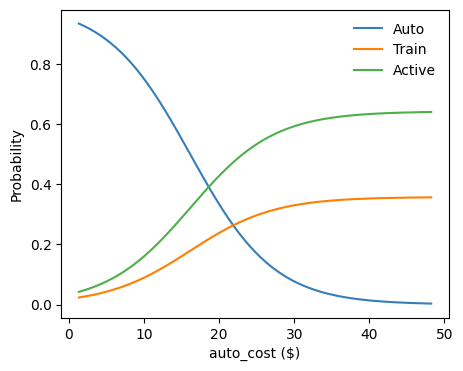

In [ ]:
# MNL model
l_prb_MNL = mnl.predict(data1_prb_lg).reshape(len(data1_prb), 3)
RUM_sub(l_prb_MNL, 'MNL')

In [ ]:
# MXL model
# l_prb_MXL = mxl.predict(data1_prb_lg, num_draws=500, seed=13).reshape(len(data1_prb), 3)
# RUM_sub(l_prb_MXL, 'MXL')

In [ ]:
data1_train_reg = gen_reg_df(data1_train, upper1, lower1)
data1_val_reg = gen_reg_df(data1_val, upper1, lower1)
data1_test_reg = gen_reg_df(data1_test, upper1, lower1)

data1_train_reg_lg = convert(data1_train_reg)
data1_val_reg_lg = convert(data1_val_reg)
data1_test_reg_lg = convert(data1_test_reg)

In [ ]:
eps = (lower1 - upper1) / 1e6

def cal_reg(l_prb_reg):
    'Function to calculate strong and weak regularities'
    diff = np.subtract(l_prb_reg[1::2], l_prb_reg[::2])
    reg_st = sum(diff < eps) / len(diff)
    reg_wk = sum(diff < -eps) / len(diff)
    print(f'Strong regularity = {reg_st:.3f}')
    print(f'Weak regularity   = {reg_wk:.3f}')
    return [reg_st, reg_wk]

In [ ]:
# MNL model
print('Training set:')
prb_reg = mnl.predict(data1_train_reg_lg).reshape(2*train_size, 3)[:, alt]
met_train_mnl.extend(cal_reg(prb_reg))

print('-'*30, '\nValidation set:')
prb_reg = mnl.predict(data1_val_reg_lg).reshape(2*val_size, 3)[:, alt]
met_val_mnl.extend(cal_reg(prb_reg))

print('-'*30, '\nTest set:')
prb_reg = mnl.predict(data1_test_reg_lg).reshape(2*test_size, 3)[:, alt]
met_test_mnl.extend(cal_reg(prb_reg))

Training set:
Strong regularity = 0.998
Weak regularity   = 1.000
------------------------------ 
Validation set:
Strong regularity = 1.000
Weak regularity   = 1.000
------------------------------ 
Test set:
Strong regularity = 0.998
Weak regularity   = 1.000


In [ ]:
# MXL model
# print('Training set:')
# prb_reg = mxl.predict(data1_train_reg_lg, num_draws=500, seed=13).reshape(2*train_size, 3)[:, alt]
# met_train_mxl.extend(cal_reg(prb_reg))

# print('-'*30, '\nValidation set:')
# prb_reg = mxl.predict(data1_val_reg_lg, num_draws=500, seed=13).reshape(2*val_size, 3)[:, alt]
# met_val_mxl.extend(cal_reg(prb_reg))

# print('-'*30, '\nTest set:')
# prb_reg = mxl.predict(data1_test_reg_lg, num_draws=500, seed=13).reshape(2*test_size, 3)[:, alt]
# met_test_mxl.extend(cal_reg(prb_reg))

In [ ]:
l_index = ['Log-likelihood', 'Accuracy', 'F1 score', 'Strong regularity', 'Weak regularity']

# results_train = pd.DataFrame({'MNL': met_train_mnl, 'MXL': met_train_mxl}, index=l_index)
# results_val = pd.DataFrame({'MNL': met_val_mnl, 'MXL': met_val_mxl}, index=l_index)
# results_test = pd.DataFrame({'MNL': met_test_mnl, 'MXL': met_test_mxl}, index=l_index)

results_train = pd.DataFrame({'MNL': met_train_mnl}, index=l_index)
results_val = pd.DataFrame({'MNL': met_val_mnl}, index=l_index)
results_test = pd.DataFrame({'MNL': met_test_mnl}, index=l_index)

results_train_std = pd.DataFrame({'MNL': 0}, index=l_index)
results_val_std = pd.DataFrame({'MNL': 0}, index=l_index)
results_test_std = pd.DataFrame({'MNL': 0}, index=l_index)

# Neural networks (NNs)

## Model structure

In [ ]:
def cal_loss(model, X, y, GR, base, lambd, criterion):
    '''
    Function to regularize the loss function
    lambd: weight of GR -> (1-lambd) is the weight of loss
    base: indicator of regularizing the sum
    '''
    loss = criterion(model(X), y)
    # Utility GR
    if GR == 'UGR':
        utl = model(X)
        g1 = grad(utl[:, 0], X, torch.ones_like(utl[:, 0]), create_graph=True)[0][:, 8:10]
        g2 = grad(utl[:, 1], X, torch.ones_like(utl[:, 1]), create_graph=True)[0][:, 10:12]
        g3 = grad(utl[:, 2], X, torch.ones_like(utl[:, 2]), create_graph=True)[0][:, 12]
    # Probability GR
    elif GR == 'PGR':
        prb = softmax(model(X), dim=1)
        g1 = grad(prb[:, 0], X, torch.ones_like(prb[:, 0]), create_graph=True)[0][:, 8:10]
        g2 = grad(prb[:, 1], X, torch.ones_like(prb[:, 1]), create_graph=True)[0][:, 10:12]
        g3 = grad(prb[:, 2], X, torch.ones_like(prb[:, 2]), create_graph=True)[0][:, 12]
    # Loss GR
    elif GR == 'LGR':
        log_prb = torch.log(softmax(model(X), dim=1))
        g1 = grad(log_prb[:, 0]*(y==0), X, torch.ones_like(log_prb[:, 0]), create_graph=True)[0][:, 8:10]
        g2 = grad(log_prb[:, 1]*(y==1), X, torch.ones_like(log_prb[:, 0]), create_graph=True)[0][:, 10:12]
        g3 = grad(log_prb[:, 2]*(y==2), X, torch.ones_like(log_prb[:, 0]), create_graph=True)[0][:, 12]
    # Without GR
    else:
        return loss

    # Sum- vs. norm-GR
    if base == 'sum':
        reg = g1[g1 > 0].sum() + g2[g2 > 0].sum() + g3[g3 > 0].sum()
    else:
        reg = torch.pow(g1, 2).sum() + torch.pow(g2, 2).sum() + torch.pow(g3, 2).sum()
    return loss + lambd * reg

In [ ]:
def train_loop(model, GR, base, lambd, optimizer, criterion):
    'Function for DNN training in each epoch'
    for X, y in train_loader:
        loss = cal_loss(model, X, y, GR, base, lambd, criterion)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return loss

In [ ]:
def cal_metrics(model, criterion, loader):
    ll = 0
    y_true, y_pred = [], []
    for X, y in loader:
        pred = model(X)
        y_true.extend(y)
        loss = criterion(pred, y).item()
        ll -= loss * len(X)
        y_pred.extend(pred.argmax(1))
    f1 = f1_score(y_true, y_pred, average='weighted')
    acc = accuracy_score(y_true, y_pred)
    return ll, acc, f1, loss

In [ ]:
def test(model, criterion):
    'Function for NN testing'
    model.eval()
    with torch.no_grad():
        # For loss, accuracy, and F1 score calculation
        met_train = cal_metrics(model, criterion, train_loader)
        met_val = cal_metrics(model, criterion, val_loader)
        met_test = cal_metrics(model, criterion, test_loader)

        # For probability calculation
        for X, _ in prb_loader:
            prb = softmax(model(X), dim=1).detach().numpy()

        # For regularity calculation
        for X_train, _ in train_reg_loader:
            prb_reg_train = softmax(model(X_train), dim=1)[:, alt].detach().numpy()
        for X_val, _ in val_reg_loader:
            prb_reg_val = softmax(model(X_val), dim=1)[:, alt].detach().numpy()
        for X_test, _ in test_reg_loader:
            prb_reg_test = softmax(model(X_test), dim=1)[:, alt].detach().numpy()
    return met_train, met_val, met_test, prb, prb_reg_train, prb_reg_val, prb_reg_test

In [ ]:
def plot_loss(agg_loss):
    'Function to plot training and validation losses per epoch'
    for l_loss in agg_loss:
        plt.plot(range(1, len(l_loss[0])+1), l_loss[0], color=l_color[0], alpha=.2)
        plt.plot(range(1, len(l_loss[1])+1), l_loss[1], color=l_color[1], alpha=.2)
    plt.xlabel('Epoch')
    plt.ylabel('Cross-entropy loss')
    plt.show()

In [ ]:
num_models = 10

def train(NN, num_epochs, GR, base, lambd):
    'Function for NN training'
    agg_loss, l_met_train, l_met_val, l_met_test, l_prb, l_prb_reg_train, l_prb_reg_val, l_prb_reg_test = [[] for i in range(8)]
    for m in range(1, num_models+1):
        torch.manual_seed(m)
        model = NN()
        l_loss_train_epoch, l_loss_val_epoch = [], []
        optimizer = torch.optim.AdamW(model.parameters(), weight_decay=0)
        criterion = nn.CrossEntropyLoss()
        for i in range(num_epochs):
            l_loss_train_epoch.append(train_loop(model, GR, base, lambd, optimizer, criterion).detach().numpy())
            model.eval()
            with torch.no_grad():
                l_loss_val_epoch.append(cal_metrics(model, criterion, val_loader)[3])
            model.train()
        agg_loss.append([l_loss_train_epoch, l_loss_val_epoch])
        met_train, met_val, met_test, prb, reg_train, reg_val, reg_test = test(model, criterion)
        [x.append(y) for x, y in zip([l_met_train, l_met_val, l_met_test, l_prb, l_prb_reg_train, l_prb_reg_val, l_prb_reg_test],
                                     [met_train, met_val, met_test, prb, reg_train, reg_val, reg_test])]
        print(f'Model {m:<2}')
        print_metrics(met_train, met_val, met_test)
    plot_loss(agg_loss)
    return l_met_train, l_met_val, l_met_test, l_prb, l_prb_reg_train, l_prb_reg_val, l_prb_reg_test

## Functions for analysis
We evaluate the models by:
- test loss, accuracy, and F1 score;
- strong and weak regularities.

In [ ]:
def NN_agg(l_met):
    'Function to analyze aggregate NN performance'
    # Averages
    avg_ll = np.mean([r[0] for r in l_met])
    avg_acc = np.mean([r[1] for r in l_met])
    avg_f1 = np.mean([r[2] for r in l_met])
    # Standard deviations
    std_ll = np.std([r[0] for r in l_met])
    std_acc = np.std([r[1] for r in l_met])
    std_f1 = np.std([r[2] for r in l_met])
    print(f'Average log-likelihood = {avg_ll:.1f} ({std_ll:.1f})')
    print(f'Average accuracy       = {avg_acc:.1%} ({std_acc:.1%})')
    print(f'Average F1 score       = {avg_f1:.1%} ({std_f1:.1%})')
    return [avg_ll, avg_acc, avg_f1], [std_ll, std_acc, std_f1]

In [ ]:
def NN_sub(l_prb, NN, base, GR, lambd):
    'Function to plot substitution patterns'
    for a in range(3):
        for p in l_prb[:, :, a]:
            plt.plot(data1_prb[var], p, color=l_color[a], alpha=.10)
        plt.plot(data1_prb[var], np.mean(l_prb[:, :, a], axis=0), color=l_color[a], label=l_alt[a])
    plt.legend(frameon=False)
    plt.xlabel(f'{var} ($)')
    plt.ylabel('Probability')
    if GR == 'none':
        plt.savefig(f'{path}/Regularity_results/{NN.__name__}_10K.png', bbox_inches='tight', dpi=200)
    else:
        plt.savefig(f'{path}/Regularity_results/{NN.__name__}_{base}_{GR}_{lambd}_10K.png', bbox_inches='tight', dpi=200)
    plt.show()

In [ ]:
def NN_reg(l_prb_reg):
    'Function to calculate strong and weak regularities for NNs'
    l_st_reg, l_wk_reg = [], []
    for prb_reg in l_prb_reg:
        diff = np.subtract(prb_reg[1::2], prb_reg[::2])
        l_st_reg.append(sum(diff < eps) / len(diff))
        l_wk_reg.append(sum(diff < -eps) / len(diff))
    avg_st_reg = np.mean(l_st_reg)
    avg_wk_reg = np.mean(l_wk_reg)
    std_st_reg = np.std(l_st_reg)
    std_wk_reg = np.std(l_wk_reg)
    print(f'Strong regularity = {avg_st_reg:.3f} ({std_st_reg:.3f})')
    print(f'Weak regularity   = {avg_wk_reg:.3f} ({std_wk_reg:.3f})')
    return [avg_st_reg, avg_wk_reg], [std_st_reg, std_wk_reg]

In [ ]:
def comparison(lambdas, agg_ll, agg_acc, agg_f1, l_st_reg, l_wk_reg, NN, base, GR):
    'Function to compare NN models'
    print('-'*30, '\nModel comparison:')
    fig, ax1 = plt.subplots()

    # Plot average test log-likelihood
    ax1.grid(linestyle='--', color='lightgray')
    ax1.plot(np.log10(lambdas), agg_ll, marker='.', color=l_color[0], label='Log-likelihood')
    ax1.set_xlabel(r'$\lg(\lambda)$')
    ax1.set_ylabel('Test log-likelihood (average)')

    # Plot average test accuracy
    ax2 = ax1.twinx()
    ax2.plot(np.log10(lambdas), agg_acc, marker='.', color=l_color[1], label='Accuracy')
    ax2.set_ylabel(r'Test accuracy, $F_1$ score, regularities (average)')

    # Plot average test F1 score
    ax2.plot(np.log10(lambdas), agg_f1, marker='.', color=l_color[2], label=r'$F_1$ score')

    # Plot average regularities
    ax2.plot(np.log10(lambdas), l_st_reg, marker='.', linestyle='dashed', color=l_color[3], label='Strong regularity')
    ax2.plot(np.log10(lambdas), l_wk_reg, marker='.', linestyle='dashed', color=l_color[4], label='Weak regularity')

    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    box = ax1.get_position()
    ax1.legend(h1+h2, l1+l2, frameon=False, loc='upper center', bbox_to_anchor=(.5, -.15), ncol=2)
    fig.savefig(f'{path}/Regularity_results/{NN.__name__}_{base}_{GR}_10K.png', bbox_inches='tight', dpi=200)

In [ ]:
def result(NN, num_epochs, GR, lambdas=[0], base='sum'):
    'Function to display all DNN results'
    agg_ll_test, agg_acc_test, agg_f1_test, l_st_reg, l_wk_reg = [[] for i in range(5)]
    for lambd in lambdas:
        print(f'Penalty = {lambd}')
        print('-'*30)
        if NN == DNN and lambd > 1:
            l_met_train, l_met_val, l_met_test, l_prb, l_prb_reg_train, l_prb_reg_val, l_prb_reg_test = train(NN, num_epochs+20, GR, base, lambd)
        else:
            l_met_train, l_met_val, l_met_test, l_prb, l_prb_reg_train, l_prb_reg_val, l_prb_reg_test = train(NN, num_epochs, GR, base, lambd)
        # Average LL, accuracy, and F1 score
        print('-'*30, '\nTraining set:')
        avg_met_train, std_met_train = NN_agg(l_met_train)
        print('-'*30, '\nValidation set:')
        avg_met_val, std_met_val = NN_agg(l_met_val)
        print('-'*30, '\nTest set:')
        avg_met_test, std_met_test = NN_agg(l_met_test)
        [x.append(y) for x, y in zip([agg_ll_test, agg_acc_test, agg_f1_test], avg_met_test)]

        # Regularities
        if GR == 'none':
            name = f'{NN.__name__}'
        else:
            name = f'{NN.__name__}, {base}-{GR} ({lambd})'
        print('-'*30, '\nTraining set:')
        [x.extend(y) for x, y in zip([avg_met_train, std_met_train], NN_reg(l_prb_reg_train))]
        results_train[name] = avg_met_train
        results_train_std[name] = std_met_train
        print('-'*30, '\nValidation set:')
        [x.extend(y) for x, y in zip([avg_met_val, std_met_val], NN_reg(l_prb_reg_val))]
        results_val[name] = avg_met_val
        results_val_std[name] = std_met_val
        print('-'*30, '\nTest set:')
        avg_reg, std_reg = NN_reg(l_prb_reg_test)
        [x.extend(y) for x, y in zip([avg_met_test, std_met_test], [avg_reg, std_reg])]
        results_test[name] = avg_met_test
        results_test_std[name] = std_met_test
        [x.append(y) for x, y in zip([l_st_reg, l_wk_reg], avg_reg)]

        # Substitution pattern
        print('-'*30)
        NN_sub(np.array(l_prb), NN, base, GR, lambd)
    if len(lambdas) > 1:
        comparison(lambdas, agg_ll_test, agg_acc_test, agg_f1_test, l_st_reg, l_wk_reg, NN, base, GR)

## Deep neural networks (DNNs)

In [ ]:
class DNN(nn.Module):
    'Class of DNNs (4 hidden layers x 100 neurons)'
    def __init__(self):
        super(DNN, self).__init__()
        self.seq = nn.Sequential(
            nn.Linear(13, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 3)
        )

    def forward(self, x):
        return self.seq(x)

### Without GR

Penalty = 0
------------------------------
Model 1 
Training set:   LL = -4267.3 | acc = 75.3% | F1 = 72.1%
Validation set: LL = -636.9  | acc = 74.3% | F1 = 71.0%
Test set:       LL = -1345.5 | acc = 72.8% | F1 = 69.2%
Model 2 
Training set:   LL = -4263.7 | acc = 74.9% | F1 = 71.8%
Validation set: LL = -630.6  | acc = 74.6% | F1 = 71.2%
Test set:       LL = -1349.2 | acc = 73.4% | F1 = 70.0%
Model 3 
Training set:   LL = -4274.0 | acc = 75.0% | F1 = 71.2%
Validation set: LL = -638.1  | acc = 73.7% | F1 = 69.6%
Test set:       LL = -1353.0 | acc = 72.9% | F1 = 68.8%
Model 4 
Training set:   LL = -4250.1 | acc = 75.5% | F1 = 72.4%
Validation set: LL = -635.2  | acc = 73.5% | F1 = 70.1%
Test set:       LL = -1347.1 | acc = 73.0% | F1 = 69.5%
Model 5 
Training set:   LL = -4266.1 | acc = 75.0% | F1 = 71.8%
Validation set: LL = -629.3  | acc = 73.6% | F1 = 70.0%
Test set:       LL = -1356.7 | acc = 73.1% | F1 = 69.6%
Model 6 
Training set:   LL = -4265.2 | acc = 75.5% | F1 = 72.3%
Validat

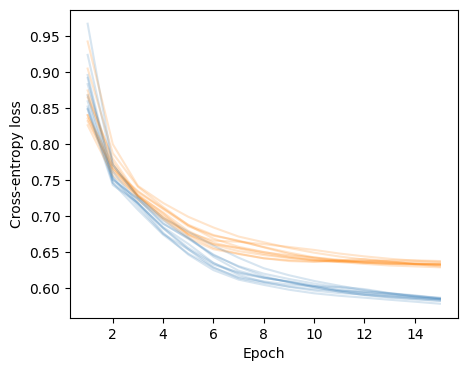

------------------------------ 
Training set:
Average log-likelihood = -4272.7 (13.0)
Average accuracy       = 75.1% (0.2%)
Average F1 score       = 71.7% (0.4%)
------------------------------ 
Validation set:
Average log-likelihood = -633.6 (2.5)
Average accuracy       = 73.9% (0.4%)
Average F1 score       = 70.2% (0.5%)
------------------------------ 
Test set:
Average log-likelihood = -1351.9 (4.7)
Average accuracy       = 72.9% (0.3%)
Average F1 score       = 69.1% (0.5%)
------------------------------ 
Training set:
Strong regularity = 0.889 (0.061)
Weak regularity   = 0.927 (0.058)
------------------------------ 
Validation set:
Strong regularity = 0.879 (0.058)
Weak regularity   = 0.928 (0.057)
------------------------------ 
Test set:
Strong regularity = 0.888 (0.066)
Weak regularity   = 0.922 (0.061)
------------------------------


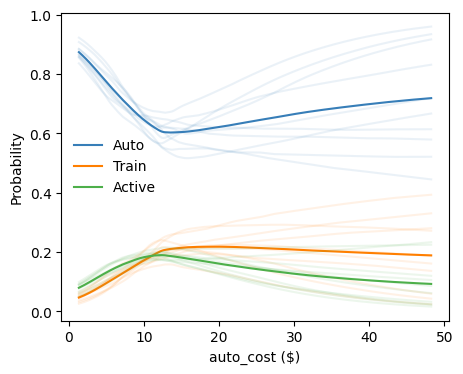

In [ ]:
result(DNN, 15, 'none')

### PGR

Penalty = 100
------------------------------
Model 1 
Training set:   LL = -4948.3 | acc = 69.5% | F1 = 57.9%
Validation set: LL = -700.3  | acc = 69.7% | F1 = 58.2%
Test set:       LL = -1508.7 | acc = 68.3% | F1 = 56.5%
Model 2 
Training set:   LL = -4889.9 | acc = 71.9% | F1 = 64.7%
Validation set: LL = -696.7  | acc = 70.5% | F1 = 63.4%
Test set:       LL = -1495.4 | acc = 69.7% | F1 = 62.2%
Model 3 
Training set:   LL = -4855.9 | acc = 71.9% | F1 = 64.9%
Validation set: LL = -692.7  | acc = 70.9% | F1 = 63.9%
Test set:       LL = -1492.3 | acc = 69.7% | F1 = 62.2%
Model 4 
Training set:   LL = -4951.3 | acc = 69.7% | F1 = 58.1%
Validation set: LL = -705.5  | acc = 69.9% | F1 = 58.3%
Test set:       LL = -1520.4 | acc = 68.0% | F1 = 55.9%
Model 5 
Training set:   LL = -4944.0 | acc = 70.2% | F1 = 60.0%
Validation set: LL = -701.1  | acc = 70.2% | F1 = 60.0%
Test set:       LL = -1502.8 | acc = 68.0% | F1 = 57.1%
Model 6 
Training set:   LL = -4889.1 | acc = 69.3% | F1 = 56.8%
Valid

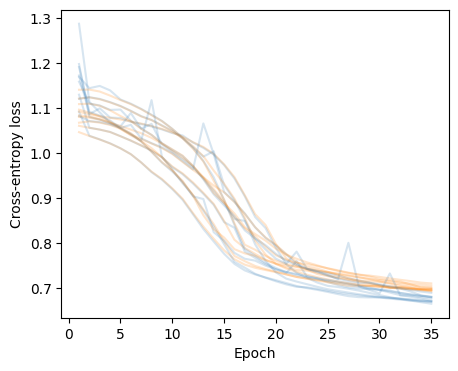

------------------------------ 
Training set:
Average log-likelihood = -4919.7 (43.2)
Average accuracy       = 70.5% (1.0%)
Average F1 score       = 60.9% (3.0%)
------------------------------ 
Validation set:
Average log-likelihood = -699.0 (5.2)
Average accuracy       = 70.1% (0.4%)
Average F1 score       = 60.6% (2.4%)
------------------------------ 
Test set:
Average log-likelihood = -1503.8 (10.9)
Average accuracy       = 68.7% (0.8%)
Average F1 score       = 58.6% (2.8%)
------------------------------ 
Training set:
Strong regularity = 1.000 (0.000)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Validation set:
Strong regularity = 1.000 (0.000)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Test set:
Strong regularity = 1.000 (0.000)
Weak regularity   = 1.000 (0.000)
------------------------------


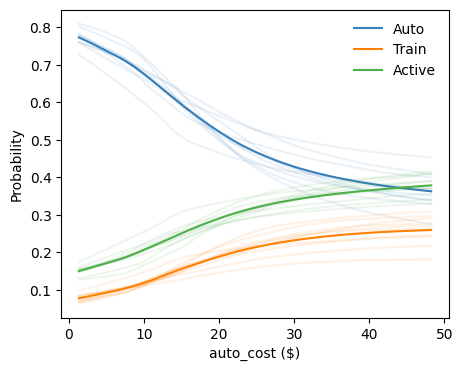

Penalty = 10
------------------------------
Model 1 
Training set:   LL = -4390.8 | acc = 74.3% | F1 = 70.3%
Validation set: LL = -652.8  | acc = 73.9% | F1 = 70.2%
Test set:       LL = -1373.4 | acc = 72.4% | F1 = 67.9%
Model 2 
Training set:   LL = -4398.1 | acc = 74.0% | F1 = 69.3%
Validation set: LL = -651.2  | acc = 73.9% | F1 = 69.4%
Test set:       LL = -1369.3 | acc = 72.2% | F1 = 67.2%
Model 3 
Training set:   LL = -4339.2 | acc = 74.4% | F1 = 70.9%
Validation set: LL = -650.8  | acc = 74.0% | F1 = 70.7%
Test set:       LL = -1362.3 | acc = 72.5% | F1 = 68.9%
Model 4 
Training set:   LL = -4448.4 | acc = 73.9% | F1 = 69.4%
Validation set: LL = -658.1  | acc = 73.6% | F1 = 69.2%
Test set:       LL = -1378.3 | acc = 72.9% | F1 = 68.3%
Model 5 
Training set:   LL = -4364.0 | acc = 74.0% | F1 = 70.6%
Validation set: LL = -642.4  | acc = 73.1% | F1 = 69.8%
Test set:       LL = -1366.3 | acc = 72.5% | F1 = 69.0%
Model 6 
Training set:   LL = -4409.1 | acc = 74.2% | F1 = 69.2%
Valida

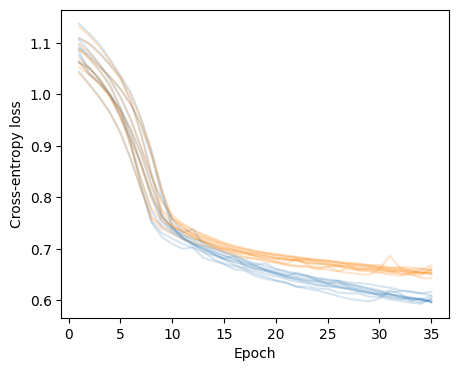

------------------------------ 
Training set:
Average log-likelihood = -4424.3 (52.9)
Average accuracy       = 74.0% (0.3%)
Average F1 score       = 69.8% (0.8%)
------------------------------ 
Validation set:
Average log-likelihood = -655.6 (6.6)
Average accuracy       = 73.3% (0.5%)
Average F1 score       = 69.2% (0.9%)
------------------------------ 
Test set:
Average log-likelihood = -1379.2 (11.5)
Average accuracy       = 72.2% (0.5%)
Average F1 score       = 67.6% (1.2%)
------------------------------ 
Training set:
Strong regularity = 0.996 (0.002)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Validation set:
Strong regularity = 0.994 (0.002)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Test set:
Strong regularity = 0.997 (0.001)
Weak regularity   = 1.000 (0.000)
------------------------------


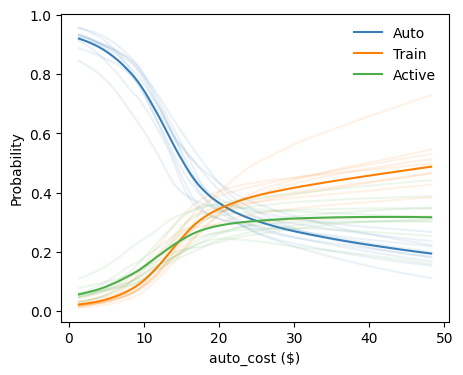

Penalty = 1
------------------------------
Model 1 
Training set:   LL = -4475.8 | acc = 73.2% | F1 = 68.8%
Validation set: LL = -663.0  | acc = 73.3% | F1 = 69.1%
Test set:       LL = -1386.8 | acc = 71.9% | F1 = 67.5%
Model 2 
Training set:   LL = -4497.2 | acc = 73.6% | F1 = 68.6%
Validation set: LL = -654.9  | acc = 73.9% | F1 = 69.3%
Test set:       LL = -1384.2 | acc = 72.2% | F1 = 67.1%
Model 3 
Training set:   LL = -4408.6 | acc = 73.8% | F1 = 70.1%
Validation set: LL = -656.7  | acc = 73.7% | F1 = 70.3%
Test set:       LL = -1362.8 | acc = 72.3% | F1 = 68.4%
Model 4 
Training set:   LL = -4518.5 | acc = 73.4% | F1 = 68.2%
Validation set: LL = -663.8  | acc = 73.0% | F1 = 68.2%
Test set:       LL = -1391.3 | acc = 71.7% | F1 = 66.3%
Model 5 
Training set:   LL = -4474.3 | acc = 73.7% | F1 = 70.2%
Validation set: LL = -655.4  | acc = 72.7% | F1 = 69.2%
Test set:       LL = -1389.8 | acc = 72.2% | F1 = 68.5%
Model 6 
Training set:   LL = -4424.7 | acc = 74.1% | F1 = 70.2%
Validat

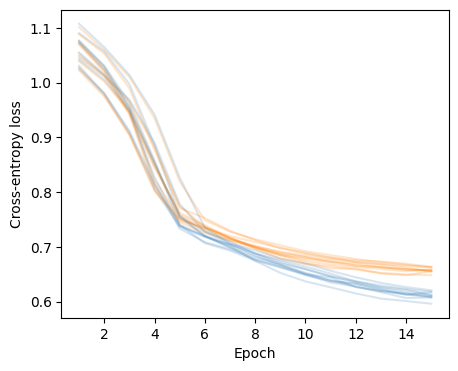

------------------------------ 
Training set:
Average log-likelihood = -4467.5 (47.8)
Average accuracy       = 73.7% (0.3%)
Average F1 score       = 69.3% (0.9%)
------------------------------ 
Validation set:
Average log-likelihood = -657.5 (4.4)
Average accuracy       = 73.1% (0.5%)
Average F1 score       = 68.9% (0.9%)
------------------------------ 
Test set:
Average log-likelihood = -1383.2 (13.1)
Average accuracy       = 72.0% (0.3%)
Average F1 score       = 67.4% (0.9%)
------------------------------ 
Training set:
Strong regularity = 0.992 (0.002)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Validation set:
Strong regularity = 0.988 (0.004)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Test set:
Strong regularity = 0.995 (0.001)
Weak regularity   = 1.000 (0.000)
------------------------------


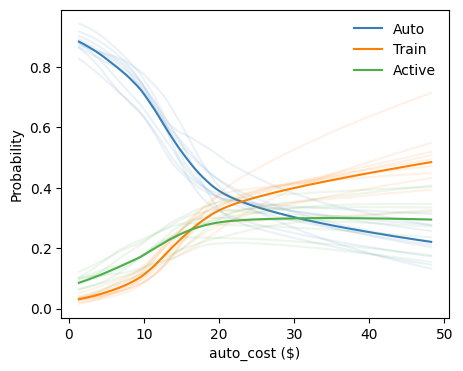

Penalty = 0.1
------------------------------
Model 1 
Training set:   LL = -4254.1 | acc = 75.1% | F1 = 72.2%
Validation set: LL = -641.7  | acc = 73.7% | F1 = 70.5%
Test set:       LL = -1349.0 | acc = 72.8% | F1 = 69.6%
Model 2 
Training set:   LL = -4273.4 | acc = 74.6% | F1 = 71.6%
Validation set: LL = -632.9  | acc = 73.8% | F1 = 70.7%
Test set:       LL = -1344.9 | acc = 73.0% | F1 = 69.5%
Model 3 
Training set:   LL = -4261.5 | acc = 74.8% | F1 = 72.1%
Validation set: LL = -639.3  | acc = 73.6% | F1 = 70.8%
Test set:       LL = -1341.0 | acc = 72.8% | F1 = 69.6%
Model 4 
Training set:   LL = -4297.1 | acc = 74.9% | F1 = 71.6%
Validation set: LL = -646.1  | acc = 74.2% | F1 = 70.5%
Test set:       LL = -1354.2 | acc = 72.8% | F1 = 69.2%
Model 5 
Training set:   LL = -4251.5 | acc = 75.1% | F1 = 72.0%
Validation set: LL = -631.2  | acc = 73.1% | F1 = 69.6%
Test set:       LL = -1348.8 | acc = 72.7% | F1 = 69.4%
Model 6 
Training set:   LL = -4265.4 | acc = 75.3% | F1 = 72.1%
Valid

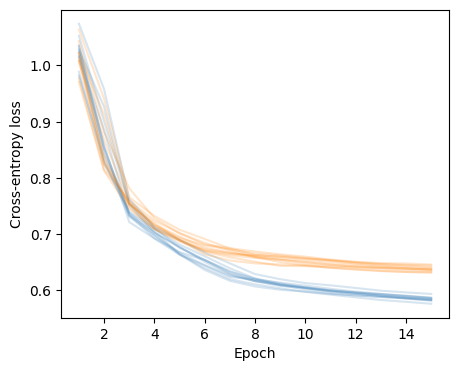

------------------------------ 
Training set:
Average log-likelihood = -4268.9 (15.9)
Average accuracy       = 75.0% (0.2%)
Average F1 score       = 71.9% (0.3%)
------------------------------ 
Validation set:
Average log-likelihood = -638.2 (4.5)
Average accuracy       = 73.7% (0.4%)
Average F1 score       = 70.3% (0.5%)
------------------------------ 
Test set:
Average log-likelihood = -1350.3 (5.8)
Average accuracy       = 72.8% (0.2%)
Average F1 score       = 69.3% (0.3%)
------------------------------ 
Training set:
Strong regularity = 0.991 (0.001)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Validation set:
Strong regularity = 0.985 (0.002)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Test set:
Strong regularity = 0.993 (0.002)
Weak regularity   = 1.000 (0.000)
------------------------------


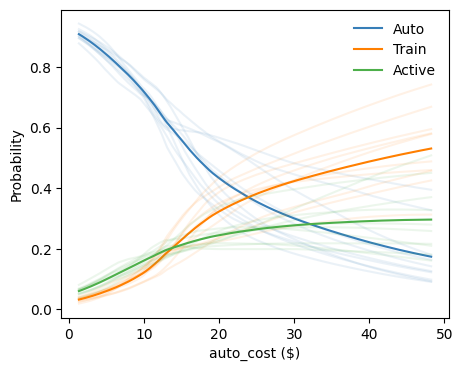

Penalty = 0.01
------------------------------
Model 1 
Training set:   LL = -4209.9 | acc = 75.7% | F1 = 73.4%
Validation set: LL = -635.6  | acc = 73.0% | F1 = 70.5%
Test set:       LL = -1339.7 | acc = 72.9% | F1 = 70.3%
Model 2 
Training set:   LL = -4230.5 | acc = 75.0% | F1 = 72.1%
Validation set: LL = -629.8  | acc = 73.9% | F1 = 70.9%
Test set:       LL = -1339.3 | acc = 73.2% | F1 = 69.9%
Model 3 
Training set:   LL = -4191.2 | acc = 75.3% | F1 = 73.1%
Validation set: LL = -634.8  | acc = 74.0% | F1 = 71.8%
Test set:       LL = -1333.7 | acc = 72.8% | F1 = 70.0%
Model 4 
Training set:   LL = -4215.6 | acc = 75.3% | F1 = 72.7%
Validation set: LL = -636.1  | acc = 74.1% | F1 = 71.3%
Test set:       LL = -1342.3 | acc = 73.2% | F1 = 70.4%
Model 5 
Training set:   LL = -4213.6 | acc = 75.3% | F1 = 72.5%
Validation set: LL = -630.2  | acc = 73.9% | F1 = 70.8%
Test set:       LL = -1348.4 | acc = 73.1% | F1 = 70.1%
Model 6 
Training set:   LL = -4220.4 | acc = 75.5% | F1 = 73.0%
Vali

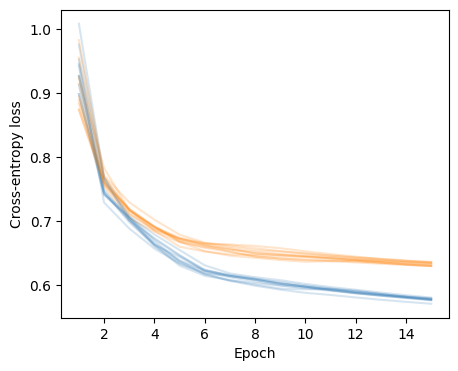

------------------------------ 
Training set:
Average log-likelihood = -4216.5 (11.7)
Average accuracy       = 75.3% (0.2%)
Average F1 score       = 72.6% (0.4%)
------------------------------ 
Validation set:
Average log-likelihood = -633.0 (2.5)
Average accuracy       = 73.9% (0.4%)
Average F1 score       = 71.0% (0.4%)
------------------------------ 
Test set:
Average log-likelihood = -1344.3 (5.5)
Average accuracy       = 73.0% (0.2%)
Average F1 score       = 69.8% (0.4%)
------------------------------ 
Training set:
Strong regularity = 0.987 (0.003)
Weak regularity   = 0.999 (0.001)
------------------------------ 
Validation set:
Strong regularity = 0.981 (0.005)
Weak regularity   = 0.999 (0.001)
------------------------------ 
Test set:
Strong regularity = 0.990 (0.003)
Weak regularity   = 0.999 (0.001)
------------------------------


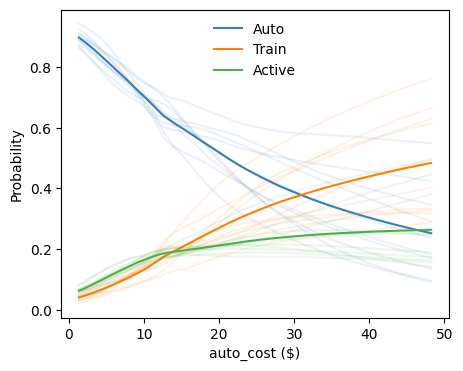

Penalty = 0.001
------------------------------
Model 1 
Training set:   LL = -4239.1 | acc = 75.6% | F1 = 73.0%
Validation set: LL = -636.5  | acc = 73.6% | F1 = 70.7%
Test set:       LL = -1342.5 | acc = 72.9% | F1 = 70.0%
Model 2 
Training set:   LL = -4244.7 | acc = 75.1% | F1 = 72.4%
Validation set: LL = -631.0  | acc = 73.8% | F1 = 70.8%
Test set:       LL = -1344.9 | acc = 73.2% | F1 = 69.9%
Model 3 
Training set:   LL = -4247.7 | acc = 75.0% | F1 = 71.8%
Validation set: LL = -640.0  | acc = 74.2% | F1 = 70.7%
Test set:       LL = -1351.1 | acc = 72.5% | F1 = 68.9%
Model 4 
Training set:   LL = -4240.6 | acc = 75.4% | F1 = 72.3%
Validation set: LL = -638.1  | acc = 73.7% | F1 = 70.2%
Test set:       LL = -1351.9 | acc = 73.0% | F1 = 69.7%
Model 5 
Training set:   LL = -4239.9 | acc = 75.1% | F1 = 72.3%
Validation set: LL = -630.5  | acc = 73.8% | F1 = 70.7%
Test set:       LL = -1353.0 | acc = 73.0% | F1 = 69.9%
Model 6 
Training set:   LL = -4253.6 | acc = 75.5% | F1 = 72.3%
Val

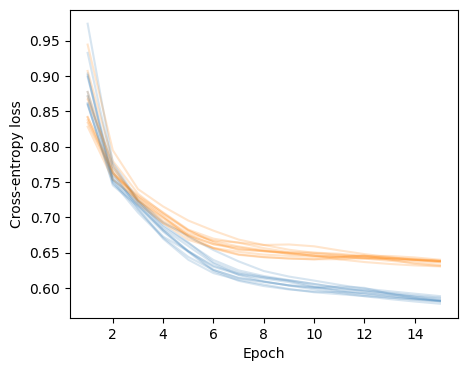

------------------------------ 
Training set:
Average log-likelihood = -4252.5 (15.3)
Average accuracy       = 75.2% (0.2%)
Average F1 score       = 72.1% (0.4%)
------------------------------ 
Validation set:
Average log-likelihood = -636.0 (3.2)
Average accuracy       = 73.8% (0.3%)
Average F1 score       = 70.4% (0.4%)
------------------------------ 
Test set:
Average log-likelihood = -1351.6 (6.3)
Average accuracy       = 72.8% (0.3%)
Average F1 score       = 69.4% (0.5%)
------------------------------ 
Training set:
Strong regularity = 0.975 (0.004)
Weak regularity   = 0.993 (0.003)
------------------------------ 
Validation set:
Strong regularity = 0.967 (0.007)
Weak regularity   = 0.993 (0.004)
------------------------------ 
Test set:
Strong regularity = 0.977 (0.005)
Weak regularity   = 0.991 (0.004)
------------------------------


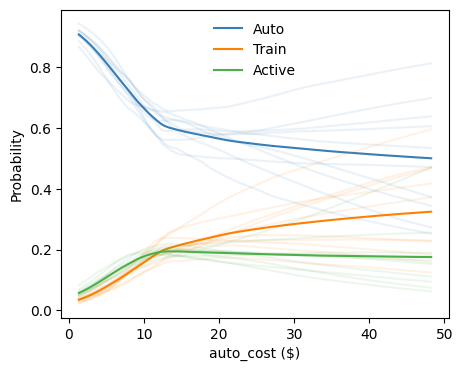

Penalty = 0.0001
------------------------------
Model 1 
Training set:   LL = -4263.1 | acc = 75.4% | F1 = 72.3%
Validation set: LL = -637.0  | acc = 74.4% | F1 = 71.1%
Test set:       LL = -1344.7 | acc = 72.9% | F1 = 69.4%
Model 2 
Training set:   LL = -4262.3 | acc = 75.0% | F1 = 71.9%
Validation set: LL = -632.0  | acc = 74.6% | F1 = 71.2%
Test set:       LL = -1349.0 | acc = 73.4% | F1 = 69.9%
Model 3 
Training set:   LL = -4272.9 | acc = 75.0% | F1 = 71.2%
Validation set: LL = -638.5  | acc = 73.7% | F1 = 69.5%
Test set:       LL = -1352.1 | acc = 72.8% | F1 = 68.7%
Model 4 
Training set:   LL = -4250.4 | acc = 75.5% | F1 = 72.3%
Validation set: LL = -636.8  | acc = 73.8% | F1 = 70.3%
Test set:       LL = -1349.3 | acc = 73.1% | F1 = 69.6%
Model 5 
Training set:   LL = -4256.4 | acc = 75.1% | F1 = 72.2%
Validation set: LL = -629.9  | acc = 73.9% | F1 = 70.8%
Test set:       LL = -1353.3 | acc = 72.9% | F1 = 69.7%
Model 6 
Training set:   LL = -4277.8 | acc = 75.2% | F1 = 71.7%
Va

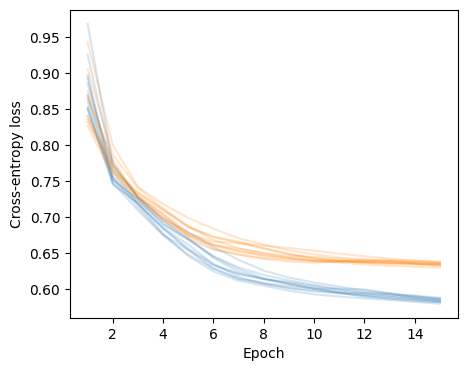

------------------------------ 
Training set:
Average log-likelihood = -4272.5 (15.4)
Average accuracy       = 75.1% (0.2%)
Average F1 score       = 71.7% (0.4%)
------------------------------ 
Validation set:
Average log-likelihood = -634.7 (2.4)
Average accuracy       = 74.0% (0.3%)
Average F1 score       = 70.3% (0.6%)
------------------------------ 
Test set:
Average log-likelihood = -1352.4 (5.9)
Average accuracy       = 72.8% (0.3%)
Average F1 score       = 69.1% (0.6%)
------------------------------ 
Training set:
Strong regularity = 0.934 (0.026)
Weak regularity   = 0.965 (0.023)
------------------------------ 
Validation set:
Strong regularity = 0.926 (0.022)
Weak regularity   = 0.969 (0.019)
------------------------------ 
Test set:
Strong regularity = 0.934 (0.029)
Weak regularity   = 0.962 (0.026)
------------------------------


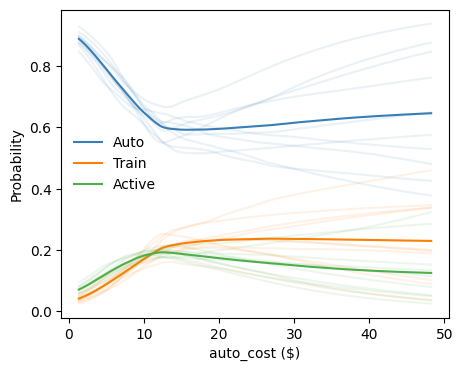

------------------------------ 
Model comparison:


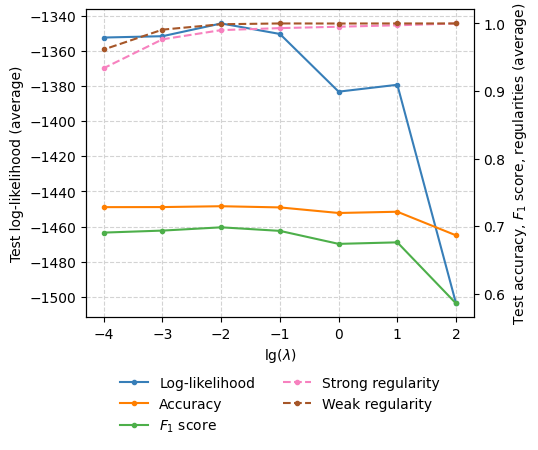

In [ ]:
# With sum
result(DNN, 15, 'PGR', [10**i for i in range(2, -5, -1)])

In [ ]:
# With norm
# result(DNN, 15, 'PGR', [10**i for i in range(2, -5, -1)], 'norm')

### UGR

Penalty = 100
------------------------------
Model 1 
Training set:   LL = -4858.4 | acc = 72.3% | F1 = 67.1%
Validation set: LL = -698.6  | acc = 71.5% | F1 = 66.5%
Test set:       LL = -1491.9 | acc = 70.5% | F1 = 65.1%
Model 2 
Training set:   LL = -4897.1 | acc = 72.2% | F1 = 65.5%
Validation set: LL = -699.4  | acc = 70.9% | F1 = 64.1%
Test set:       LL = -1493.2 | acc = 70.0% | F1 = 62.9%
Model 3 
Training set:   LL = -4898.8 | acc = 72.4% | F1 = 66.6%
Validation set: LL = -697.9  | acc = 71.4% | F1 = 65.7%
Test set:       LL = -1501.1 | acc = 70.7% | F1 = 64.4%
Model 4 
Training set:   LL = -4835.9 | acc = 72.5% | F1 = 66.7%
Validation set: LL = -691.1  | acc = 71.1% | F1 = 65.5%
Test set:       LL = -1479.8 | acc = 70.7% | F1 = 64.8%
Model 5 
Training set:   LL = -4868.1 | acc = 72.8% | F1 = 66.8%
Validation set: LL = -694.7  | acc = 71.8% | F1 = 65.9%
Test set:       LL = -1479.1 | acc = 71.0% | F1 = 64.7%
Model 6 
Training set:   LL = -4899.4 | acc = 69.3% | F1 = 56.8%
Valid

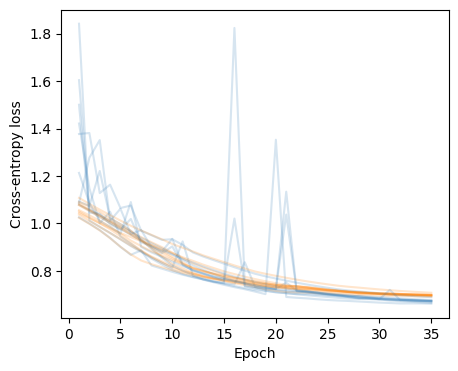

------------------------------ 
Training set:
Average log-likelihood = -4889.8 (38.9)
Average accuracy       = 72.0% (1.0%)
Average F1 score       = 65.1% (3.1%)
------------------------------ 
Validation set:
Average log-likelihood = -697.5 (4.1)
Average accuracy       = 71.2% (0.7%)
Average F1 score       = 64.4% (2.7%)
------------------------------ 
Test set:
Average log-likelihood = -1493.9 (11.2)
Average accuracy       = 70.1% (0.9%)
Average F1 score       = 62.9% (3.1%)
------------------------------ 
Training set:
Strong regularity = 0.947 (0.097)
Weak regularity   = 0.966 (0.063)
------------------------------ 
Validation set:
Strong regularity = 0.945 (0.101)
Weak regularity   = 0.964 (0.066)
------------------------------ 
Test set:
Strong regularity = 0.944 (0.101)
Weak regularity   = 0.962 (0.069)
------------------------------


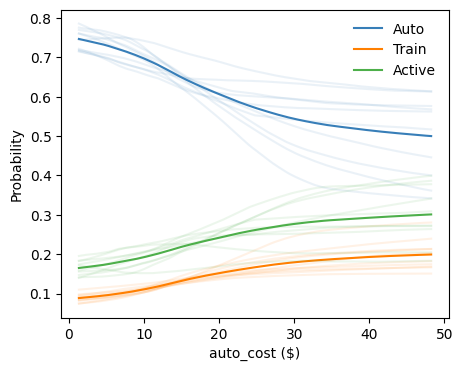

Penalty = 10
------------------------------
Model 1 
Training set:   LL = -4545.6 | acc = 73.5% | F1 = 68.4%
Validation set: LL = -666.9  | acc = 73.1% | F1 = 68.3%
Test set:       LL = -1415.1 | acc = 71.9% | F1 = 66.8%
Model 2 
Training set:   LL = -4590.4 | acc = 73.5% | F1 = 68.2%
Validation set: LL = -668.7  | acc = 73.4% | F1 = 68.4%
Test set:       LL = -1407.8 | acc = 71.9% | F1 = 66.6%
Model 3 
Training set:   LL = -4528.2 | acc = 73.2% | F1 = 68.1%
Validation set: LL = -656.9  | acc = 73.7% | F1 = 69.0%
Test set:       LL = -1402.9 | acc = 71.4% | F1 = 66.0%
Model 4 
Training set:   LL = -4482.4 | acc = 74.1% | F1 = 69.9%
Validation set: LL = -663.0  | acc = 73.6% | F1 = 69.6%
Test set:       LL = -1393.7 | acc = 72.8% | F1 = 68.5%
Model 5 
Training set:   LL = -4541.6 | acc = 73.9% | F1 = 69.0%
Validation set: LL = -652.6  | acc = 73.6% | F1 = 68.9%
Test set:       LL = -1409.8 | acc = 71.4% | F1 = 66.2%
Model 6 
Training set:   LL = -4496.1 | acc = 73.5% | F1 = 68.7%
Valida

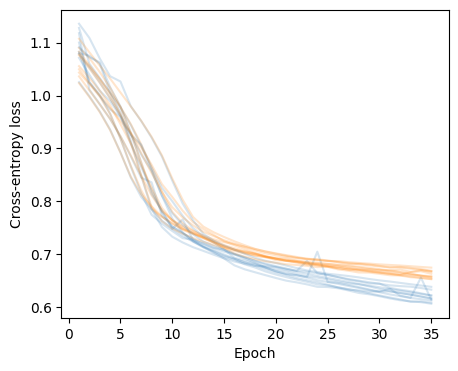

------------------------------ 
Training set:
Average log-likelihood = -4552.2 (73.5)
Average accuracy       = 73.5% (0.3%)
Average F1 score       = 68.5% (0.6%)
------------------------------ 
Validation set:
Average log-likelihood = -661.8 (7.1)
Average accuracy       = 73.2% (0.4%)
Average F1 score       = 68.6% (0.6%)
------------------------------ 
Test set:
Average log-likelihood = -1408.7 (19.0)
Average accuracy       = 71.8% (0.4%)
Average F1 score       = 66.7% (0.7%)
------------------------------ 
Training set:
Strong regularity = 0.953 (0.113)
Weak regularity   = 0.958 (0.104)
------------------------------ 
Validation set:
Strong regularity = 0.951 (0.116)
Weak regularity   = 0.956 (0.108)
------------------------------ 
Test set:
Strong regularity = 0.954 (0.114)
Weak regularity   = 0.958 (0.104)
------------------------------


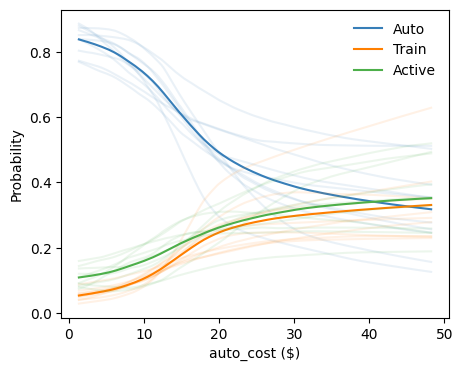

Penalty = 1
------------------------------
Model 1 
Training set:   LL = -4647.6 | acc = 72.9% | F1 = 67.6%
Validation set: LL = -669.2  | acc = 72.2% | F1 = 67.3%
Test set:       LL = -1428.1 | acc = 70.5% | F1 = 65.2%
Model 2 
Training set:   LL = -4726.1 | acc = 72.1% | F1 = 65.4%
Validation set: LL = -677.2  | acc = 70.9% | F1 = 64.3%
Test set:       LL = -1445.9 | acc = 70.2% | F1 = 63.5%
Model 3 
Training set:   LL = -4589.5 | acc = 73.1% | F1 = 68.2%
Validation set: LL = -665.4  | acc = 72.8% | F1 = 68.2%
Test set:       LL = -1412.5 | acc = 71.8% | F1 = 66.7%
Model 4 
Training set:   LL = -4659.1 | acc = 72.8% | F1 = 67.2%
Validation set: LL = -675.1  | acc = 71.5% | F1 = 66.3%
Test set:       LL = -1424.8 | acc = 71.1% | F1 = 65.4%
Model 5 
Training set:   LL = -4720.1 | acc = 72.9% | F1 = 67.3%
Validation set: LL = -672.9  | acc = 72.2% | F1 = 66.8%
Test set:       LL = -1450.0 | acc = 71.0% | F1 = 65.2%
Model 6 
Training set:   LL = -4696.3 | acc = 72.3% | F1 = 65.8%
Validat

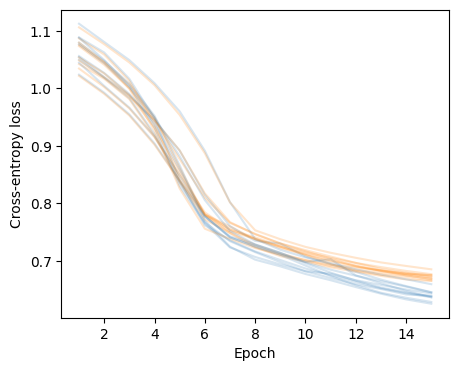

------------------------------ 
Training set:
Average log-likelihood = -4687.9 (65.0)
Average accuracy       = 72.7% (0.4%)
Average F1 score       = 66.9% (1.1%)
------------------------------ 
Validation set:
Average log-likelihood = -672.8 (5.7)
Average accuracy       = 71.9% (0.7%)
Average F1 score       = 66.4% (1.4%)
------------------------------ 
Test set:
Average log-likelihood = -1438.2 (20.3)
Average accuracy       = 70.9% (0.5%)
Average F1 score       = 65.0% (1.2%)
------------------------------ 
Training set:
Strong regularity = 0.981 (0.026)
Weak regularity   = 0.988 (0.020)
------------------------------ 
Validation set:
Strong regularity = 0.981 (0.026)
Weak regularity   = 0.987 (0.020)
------------------------------ 
Test set:
Strong regularity = 0.981 (0.026)
Weak regularity   = 0.988 (0.019)
------------------------------


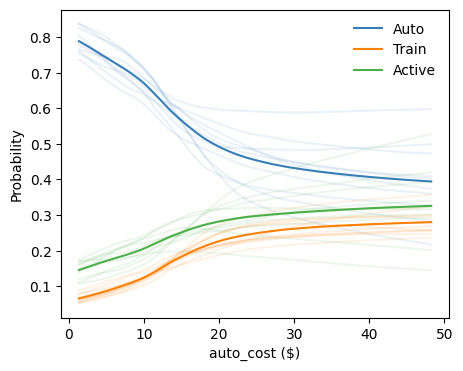

Penalty = 0.1
------------------------------
Model 1 
Training set:   LL = -4337.8 | acc = 74.6% | F1 = 70.6%
Validation set: LL = -650.5  | acc = 73.8% | F1 = 69.6%
Test set:       LL = -1365.0 | acc = 72.7% | F1 = 68.4%
Model 2 
Training set:   LL = -4358.6 | acc = 74.3% | F1 = 70.3%
Validation set: LL = -641.1  | acc = 74.2% | F1 = 70.2%
Test set:       LL = -1354.9 | acc = 72.8% | F1 = 68.7%
Model 3 
Training set:   LL = -4301.2 | acc = 74.6% | F1 = 71.4%
Validation set: LL = -639.4  | acc = 74.1% | F1 = 70.6%
Test set:       LL = -1348.3 | acc = 72.7% | F1 = 69.1%
Model 4 
Training set:   LL = -4340.2 | acc = 74.9% | F1 = 71.2%
Validation set: LL = -650.0  | acc = 74.0% | F1 = 70.1%
Test set:       LL = -1359.9 | acc = 73.1% | F1 = 69.2%
Model 5 
Training set:   LL = -4343.2 | acc = 74.8% | F1 = 70.8%
Validation set: LL = -637.0  | acc = 73.4% | F1 = 69.3%
Test set:       LL = -1363.8 | acc = 72.5% | F1 = 68.4%
Model 6 
Training set:   LL = -4329.9 | acc = 74.9% | F1 = 71.2%
Valid

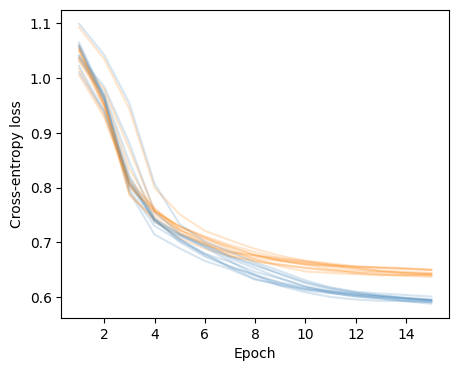

------------------------------ 
Training set:
Average log-likelihood = -4339.5 (19.3)
Average accuracy       = 74.6% (0.2%)
Average F1 score       = 70.7% (0.5%)
------------------------------ 
Validation set:
Average log-likelihood = -643.8 (4.5)
Average accuracy       = 73.8% (0.3%)
Average F1 score       = 69.8% (0.5%)
------------------------------ 
Test set:
Average log-likelihood = -1359.9 (6.5)
Average accuracy       = 72.6% (0.3%)
Average F1 score       = 68.5% (0.6%)
------------------------------ 
Training set:
Strong regularity = 0.986 (0.003)
Weak regularity   = 0.998 (0.002)
------------------------------ 
Validation set:
Strong regularity = 0.981 (0.004)
Weak regularity   = 0.998 (0.002)
------------------------------ 
Test set:
Strong regularity = 0.989 (0.004)
Weak regularity   = 0.998 (0.003)
------------------------------


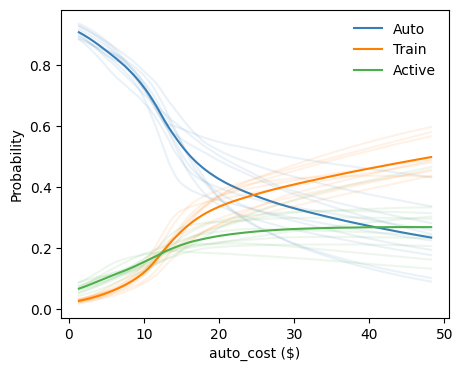

Penalty = 0.01
------------------------------
Model 1 
Training set:   LL = -4233.7 | acc = 75.3% | F1 = 72.3%
Validation set: LL = -636.9  | acc = 73.8% | F1 = 70.5%
Test set:       LL = -1348.7 | acc = 73.2% | F1 = 69.8%
Model 2 
Training set:   LL = -4253.3 | acc = 74.9% | F1 = 71.7%
Validation set: LL = -630.1  | acc = 74.2% | F1 = 70.6%
Test set:       LL = -1344.0 | acc = 73.2% | F1 = 69.7%
Model 3 
Training set:   LL = -4218.1 | acc = 75.3% | F1 = 72.4%
Validation set: LL = -630.5  | acc = 74.1% | F1 = 70.9%
Test set:       LL = -1343.0 | acc = 73.0% | F1 = 69.6%
Model 4 
Training set:   LL = -4239.0 | acc = 75.4% | F1 = 72.4%
Validation set: LL = -637.5  | acc = 73.6% | F1 = 70.3%
Test set:       LL = -1350.6 | acc = 73.1% | F1 = 69.7%
Model 5 
Training set:   LL = -4230.3 | acc = 75.2% | F1 = 72.0%
Validation set: LL = -629.7  | acc = 74.0% | F1 = 70.3%
Test set:       LL = -1355.9 | acc = 72.9% | F1 = 69.2%
Model 6 
Training set:   LL = -4254.6 | acc = 75.4% | F1 = 72.1%
Vali

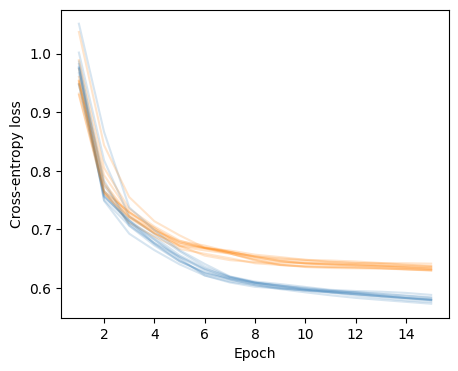

------------------------------ 
Training set:
Average log-likelihood = -4240.1 (15.4)
Average accuracy       = 75.2% (0.2%)
Average F1 score       = 72.1% (0.3%)
------------------------------ 
Validation set:
Average log-likelihood = -634.1 (3.6)
Average accuracy       = 73.9% (0.3%)
Average F1 score       = 70.5% (0.5%)
------------------------------ 
Test set:
Average log-likelihood = -1350.2 (5.8)
Average accuracy       = 72.9% (0.2%)
Average F1 score       = 69.4% (0.4%)
------------------------------ 
Training set:
Strong regularity = 0.980 (0.011)
Weak regularity   = 0.997 (0.004)
------------------------------ 
Validation set:
Strong regularity = 0.973 (0.014)
Weak regularity   = 0.997 (0.004)
------------------------------ 
Test set:
Strong regularity = 0.982 (0.012)
Weak regularity   = 0.996 (0.006)
------------------------------


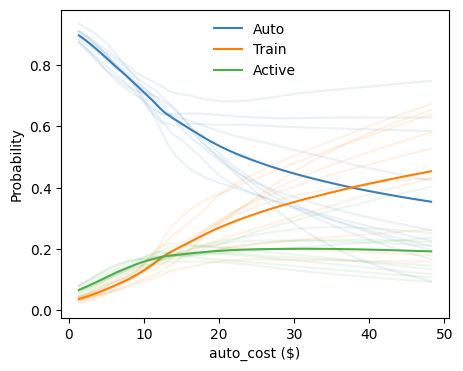

Penalty = 0.001
------------------------------
Model 1 
Training set:   LL = -4234.4 | acc = 75.5% | F1 = 72.7%
Validation set: LL = -636.0  | acc = 73.6% | F1 = 70.5%
Test set:       LL = -1344.5 | acc = 73.0% | F1 = 70.0%
Model 2 
Training set:   LL = -4242.9 | acc = 75.0% | F1 = 72.1%
Validation set: LL = -629.4  | acc = 74.3% | F1 = 71.3%
Test set:       LL = -1343.4 | acc = 73.2% | F1 = 69.9%
Model 3 
Training set:   LL = -4217.9 | acc = 75.3% | F1 = 72.3%
Validation set: LL = -632.2  | acc = 73.9% | F1 = 70.5%
Test set:       LL = -1348.1 | acc = 72.6% | F1 = 69.1%
Model 4 
Training set:   LL = -4252.7 | acc = 75.3% | F1 = 72.1%
Validation set: LL = -639.7  | acc = 74.0% | F1 = 70.5%
Test set:       LL = -1354.8 | acc = 72.8% | F1 = 69.3%
Model 5 
Training set:   LL = -4224.1 | acc = 75.2% | F1 = 72.5%
Validation set: LL = -628.7  | acc = 74.4% | F1 = 71.5%
Test set:       LL = -1350.5 | acc = 73.0% | F1 = 70.0%
Model 6 
Training set:   LL = -4231.2 | acc = 75.6% | F1 = 72.7%
Val

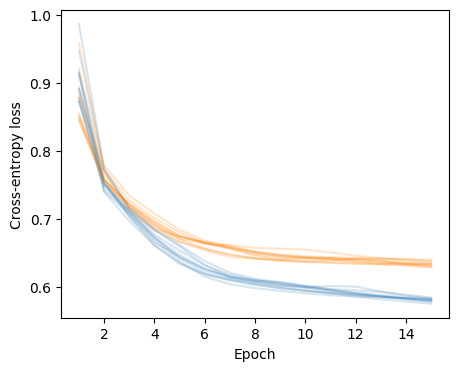

------------------------------ 
Training set:
Average log-likelihood = -4235.5 (15.9)
Average accuracy       = 75.2% (0.2%)
Average F1 score       = 72.3% (0.4%)
------------------------------ 
Validation set:
Average log-likelihood = -633.4 (3.4)
Average accuracy       = 73.9% (0.4%)
Average F1 score       = 70.7% (0.5%)
------------------------------ 
Test set:
Average log-likelihood = -1349.9 (5.5)
Average accuracy       = 72.8% (0.3%)
Average F1 score       = 69.4% (0.5%)
------------------------------ 
Training set:
Strong regularity = 0.976 (0.010)
Weak regularity   = 0.993 (0.008)
------------------------------ 
Validation set:
Strong regularity = 0.971 (0.009)
Weak regularity   = 0.994 (0.007)
------------------------------ 
Test set:
Strong regularity = 0.978 (0.012)
Weak regularity   = 0.991 (0.009)
------------------------------


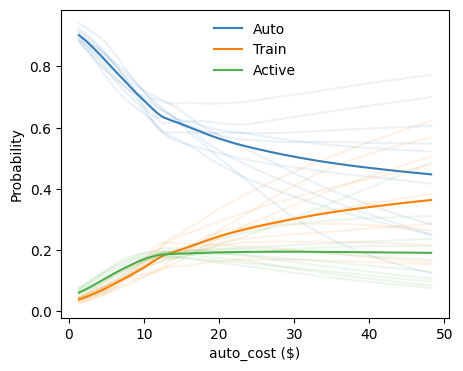

Penalty = 0.0001
------------------------------
Model 1 
Training set:   LL = -4257.0 | acc = 75.5% | F1 = 72.5%
Validation set: LL = -636.7  | acc = 73.9% | F1 = 70.6%
Test set:       LL = -1345.1 | acc = 72.8% | F1 = 69.4%
Model 2 
Training set:   LL = -4262.0 | acc = 75.0% | F1 = 71.8%
Validation set: LL = -632.1  | acc = 74.3% | F1 = 70.8%
Test set:       LL = -1352.0 | acc = 73.2% | F1 = 69.7%
Model 3 
Training set:   LL = -4259.0 | acc = 75.0% | F1 = 71.5%
Validation set: LL = -638.0  | acc = 74.0% | F1 = 70.3%
Test set:       LL = -1354.2 | acc = 72.6% | F1 = 68.7%
Model 4 
Training set:   LL = -4250.2 | acc = 75.5% | F1 = 72.4%
Validation set: LL = -636.8  | acc = 74.0% | F1 = 70.6%
Test set:       LL = -1352.2 | acc = 73.0% | F1 = 69.4%
Model 5 
Training set:   LL = -4251.5 | acc = 75.0% | F1 = 72.2%
Validation set: LL = -629.7  | acc = 74.5% | F1 = 71.6%
Test set:       LL = -1353.3 | acc = 73.0% | F1 = 69.8%
Model 6 
Training set:   LL = -4273.6 | acc = 75.4% | F1 = 72.1%
Va

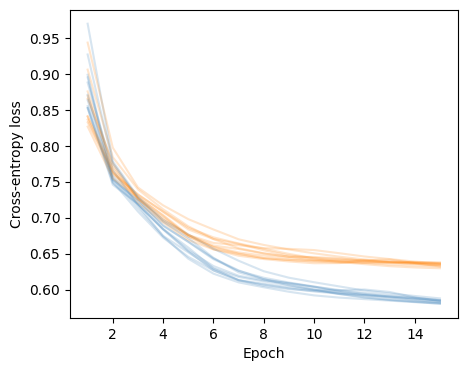

------------------------------ 
Training set:
Average log-likelihood = -4266.7 (15.0)
Average accuracy       = 75.2% (0.2%)
Average F1 score       = 71.9% (0.4%)
------------------------------ 
Validation set:
Average log-likelihood = -634.5 (2.4)
Average accuracy       = 74.0% (0.4%)
Average F1 score       = 70.4% (0.6%)
------------------------------ 
Test set:
Average log-likelihood = -1353.0 (4.7)
Average accuracy       = 72.8% (0.3%)
Average F1 score       = 69.1% (0.5%)
------------------------------ 
Training set:
Strong regularity = 0.951 (0.019)
Weak regularity   = 0.976 (0.016)
------------------------------ 
Validation set:
Strong regularity = 0.946 (0.019)
Weak regularity   = 0.979 (0.014)
------------------------------ 
Test set:
Strong regularity = 0.953 (0.022)
Weak regularity   = 0.973 (0.018)
------------------------------


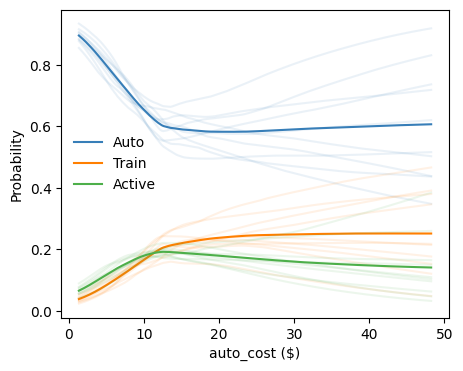

------------------------------ 
Model comparison:


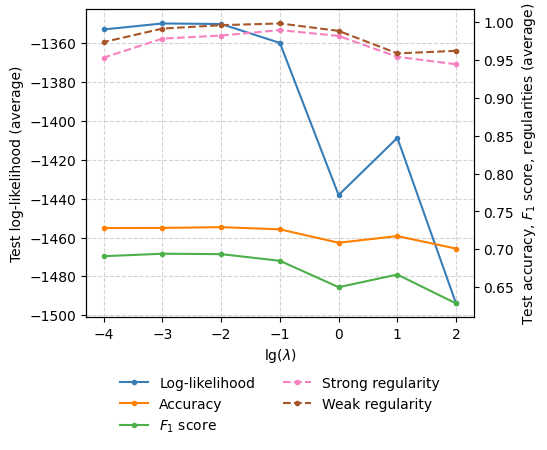

In [ ]:
# With sum
result(DNN, 15, 'UGR', [10**i for i in range(2, -5, -1)])

In [ ]:
# With norm
# result(DNN, 15, 'UGR', [10**i for i in range(2, -5, -1)], 'norm')

### LGR

Penalty = 100
------------------------------
Model 1 
Training set:   LL = -5074.5 | acc = 69.3% | F1 = 56.7%
Validation set: LL = -715.2  | acc = 69.7% | F1 = 57.3%
Test set:       LL = -1536.1 | acc = 67.8% | F1 = 54.8%
Model 2 
Training set:   LL = -4881.7 | acc = 69.3% | F1 = 56.8%
Validation set: LL = -693.7  | acc = 69.7% | F1 = 57.3%
Test set:       LL = -1491.7 | acc = 67.8% | F1 = 54.8%
Model 3 
Training set:   LL = -5069.2 | acc = 69.3% | F1 = 56.7%
Validation set: LL = -720.5  | acc = 69.7% | F1 = 57.3%
Test set:       LL = -1531.0 | acc = 67.8% | F1 = 54.8%
Model 4 
Training set:   LL = -4967.3 | acc = 69.3% | F1 = 56.7%
Validation set: LL = -704.4  | acc = 69.7% | F1 = 57.3%
Test set:       LL = -1520.3 | acc = 67.8% | F1 = 54.8%
Model 5 
Training set:   LL = -5173.8 | acc = 69.3% | F1 = 56.7%
Validation set: LL = -727.9  | acc = 69.7% | F1 = 57.3%
Test set:       LL = -1552.4 | acc = 67.8% | F1 = 54.8%
Model 6 
Training set:   LL = -5056.7 | acc = 69.3% | F1 = 56.7%
Valid

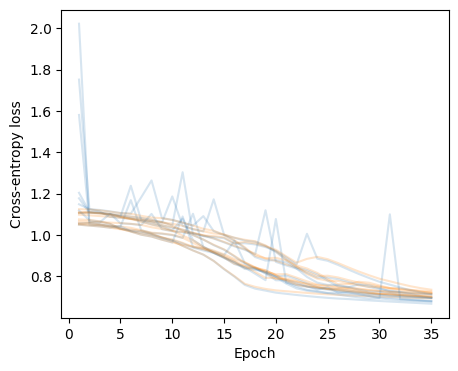

------------------------------ 
Training set:
Average log-likelihood = -5040.2 (92.8)
Average accuracy       = 69.4% (0.2%)
Average F1 score       = 57.0% (0.8%)
------------------------------ 
Validation set:
Average log-likelihood = -714.0 (12.8)
Average accuracy       = 69.8% (0.2%)
Average F1 score       = 57.5% (0.7%)
------------------------------ 
Test set:
Average log-likelihood = -1527.0 (21.1)
Average accuracy       = 67.8% (0.1%)
Average F1 score       = 55.0% (0.6%)
------------------------------ 
Training set:
Strong regularity = 1.000 (0.000)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Validation set:
Strong regularity = 1.000 (0.000)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Test set:
Strong regularity = 1.000 (0.000)
Weak regularity   = 1.000 (0.000)
------------------------------


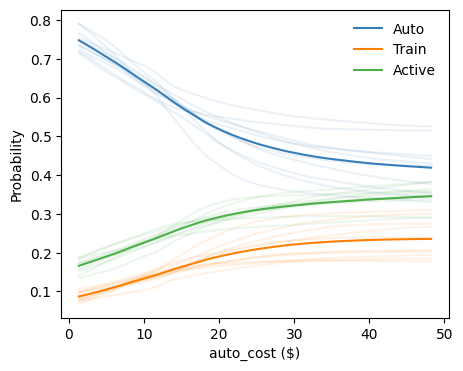

Penalty = 10
------------------------------
Model 1 
Training set:   LL = -4564.7 | acc = 73.6% | F1 = 69.0%
Validation set: LL = -670.5  | acc = 73.2% | F1 = 68.8%
Test set:       LL = -1422.1 | acc = 71.7% | F1 = 67.0%
Model 2 
Training set:   LL = -4632.1 | acc = 73.1% | F1 = 67.5%
Validation set: LL = -671.2  | acc = 73.3% | F1 = 67.8%
Test set:       LL = -1427.2 | acc = 71.3% | F1 = 65.4%
Model 3 
Training set:   LL = -4556.3 | acc = 73.6% | F1 = 69.0%
Validation set: LL = -675.1  | acc = 72.8% | F1 = 68.5%
Test set:       LL = -1422.6 | acc = 72.0% | F1 = 67.3%
Model 4 
Training set:   LL = -4612.6 | acc = 73.2% | F1 = 67.8%
Validation set: LL = -667.0  | acc = 73.6% | F1 = 68.8%
Test set:       LL = -1419.1 | acc = 71.9% | F1 = 66.3%
Model 5 
Training set:   LL = -4693.9 | acc = 72.7% | F1 = 67.5%
Validation set: LL = -672.4  | acc = 71.6% | F1 = 66.5%
Test set:       LL = -1449.5 | acc = 71.6% | F1 = 66.1%
Model 6 
Training set:   LL = -4474.8 | acc = 73.3% | F1 = 69.0%
Valida

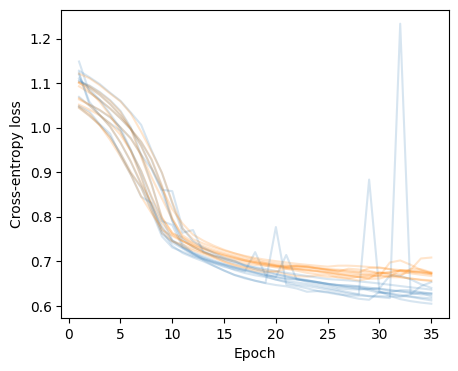

------------------------------ 
Training set:
Average log-likelihood = -4608.4 (102.2)
Average accuracy       = 72.9% (1.1%)
Average F1 score       = 67.6% (2.4%)
------------------------------ 
Validation set:
Average log-likelihood = -672.4 (13.7)
Average accuracy       = 72.4% (1.3%)
Average F1 score       = 67.4% (2.5%)
------------------------------ 
Test set:
Average log-likelihood = -1426.0 (29.1)
Average accuracy       = 71.2% (1.1%)
Average F1 score       = 65.7% (2.6%)
------------------------------ 
Training set:
Strong regularity = 0.998 (0.001)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Validation set:
Strong regularity = 0.998 (0.002)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Test set:
Strong regularity = 0.999 (0.001)
Weak regularity   = 1.000 (0.000)
------------------------------


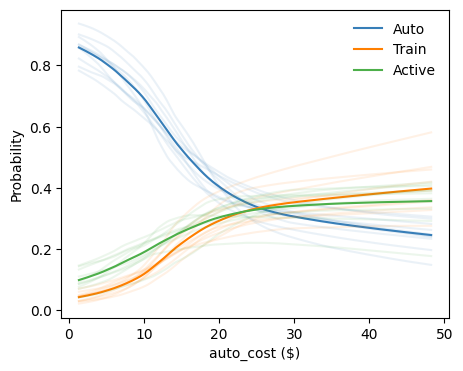

Penalty = 1
------------------------------
Model 1 
Training set:   LL = -4514.7 | acc = 73.4% | F1 = 68.5%
Validation set: LL = -661.4  | acc = 73.8% | F1 = 69.1%
Test set:       LL = -1397.5 | acc = 71.5% | F1 = 66.6%
Model 2 
Training set:   LL = -4620.0 | acc = 73.1% | F1 = 67.3%
Validation set: LL = -668.3  | acc = 73.1% | F1 = 67.3%
Test set:       LL = -1420.7 | acc = 71.4% | F1 = 65.5%
Model 3 
Training set:   LL = -4478.4 | acc = 73.9% | F1 = 69.3%
Validation set: LL = -659.4  | acc = 73.8% | F1 = 69.2%
Test set:       LL = -1380.8 | acc = 72.5% | F1 = 67.8%
Model 4 
Training set:   LL = -4570.5 | acc = 73.3% | F1 = 68.2%
Validation set: LL = -669.1  | acc = 72.7% | F1 = 68.0%
Test set:       LL = -1403.2 | acc = 71.5% | F1 = 66.2%
Model 5 
Training set:   LL = -4541.9 | acc = 73.4% | F1 = 68.6%
Validation set: LL = -653.3  | acc = 73.0% | F1 = 68.6%
Test set:       LL = -1401.1 | acc = 71.6% | F1 = 67.0%
Model 6 
Training set:   LL = -4549.2 | acc = 73.0% | F1 = 67.4%
Validat

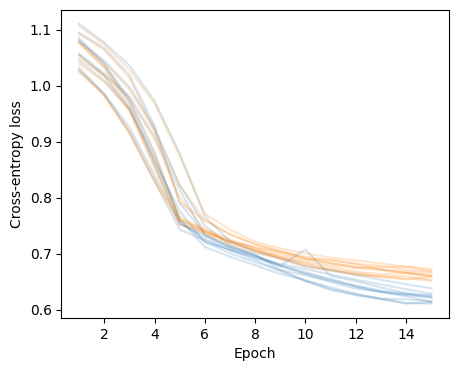

------------------------------ 
Training set:
Average log-likelihood = -4551.4 (68.7)
Average accuracy       = 73.3% (0.4%)
Average F1 score       = 68.3% (1.1%)
------------------------------ 
Validation set:
Average log-likelihood = -662.1 (6.4)
Average accuracy       = 72.9% (0.6%)
Average F1 score       = 68.1% (1.2%)
------------------------------ 
Test set:
Average log-likelihood = -1401.1 (20.6)
Average accuracy       = 71.5% (0.5%)
Average F1 score       = 66.3% (1.2%)
------------------------------ 
Training set:
Strong regularity = 0.995 (0.002)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Validation set:
Strong regularity = 0.992 (0.003)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Test set:
Strong regularity = 0.996 (0.001)
Weak regularity   = 1.000 (0.000)
------------------------------


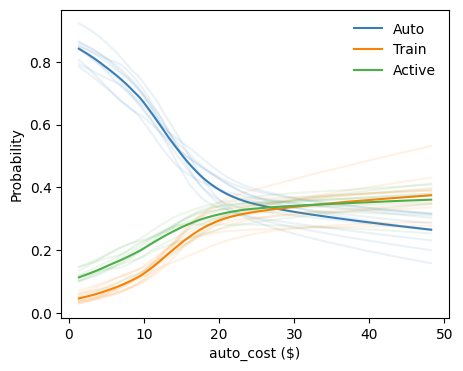

Penalty = 0.1
------------------------------
Model 1 
Training set:   LL = -4268.6 | acc = 75.1% | F1 = 72.2%
Validation set: LL = -644.0  | acc = 73.7% | F1 = 70.6%
Test set:       LL = -1351.9 | acc = 72.7% | F1 = 69.5%
Model 2 
Training set:   LL = -4301.5 | acc = 74.5% | F1 = 71.2%
Validation set: LL = -633.5  | acc = 74.2% | F1 = 70.7%
Test set:       LL = -1346.8 | acc = 73.0% | F1 = 69.3%
Model 3 
Training set:   LL = -4262.8 | acc = 74.7% | F1 = 71.7%
Validation set: LL = -643.0  | acc = 73.9% | F1 = 70.8%
Test set:       LL = -1346.7 | acc = 73.1% | F1 = 69.7%
Model 4 
Training set:   LL = -4293.1 | acc = 74.9% | F1 = 72.0%
Validation set: LL = -644.8  | acc = 73.9% | F1 = 70.8%
Test set:       LL = -1350.1 | acc = 73.2% | F1 = 70.1%
Model 5 
Training set:   LL = -4281.6 | acc = 75.0% | F1 = 71.9%
Validation set: LL = -633.2  | acc = 73.5% | F1 = 70.1%
Test set:       LL = -1349.0 | acc = 72.9% | F1 = 69.6%
Model 6 
Training set:   LL = -4278.8 | acc = 75.0% | F1 = 71.9%
Valid

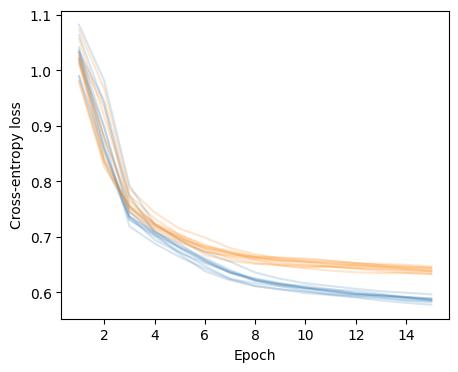

------------------------------ 
Training set:
Average log-likelihood = -4285.9 (19.0)
Average accuracy       = 74.9% (0.2%)
Average F1 score       = 71.7% (0.4%)
------------------------------ 
Validation set:
Average log-likelihood = -639.9 (4.5)
Average accuracy       = 73.7% (0.4%)
Average F1 score       = 70.4% (0.4%)
------------------------------ 
Test set:
Average log-likelihood = -1352.2 (5.8)
Average accuracy       = 72.8% (0.3%)
Average F1 score       = 69.3% (0.5%)
------------------------------ 
Training set:
Strong regularity = 0.991 (0.001)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Validation set:
Strong regularity = 0.987 (0.003)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Test set:
Strong regularity = 0.993 (0.001)
Weak regularity   = 1.000 (0.000)
------------------------------


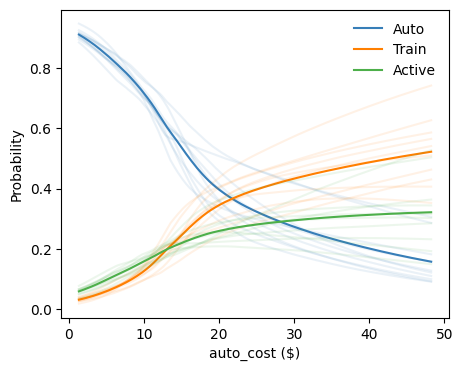

Penalty = 0.01
------------------------------
Model 1 
Training set:   LL = -4207.8 | acc = 75.7% | F1 = 73.3%
Validation set: LL = -636.0  | acc = 73.6% | F1 = 71.0%
Test set:       LL = -1339.5 | acc = 72.8% | F1 = 70.0%
Model 2 
Training set:   LL = -4235.6 | acc = 74.9% | F1 = 71.9%
Validation set: LL = -630.6  | acc = 73.9% | F1 = 70.7%
Test set:       LL = -1343.4 | acc = 73.3% | F1 = 69.9%
Model 3 
Training set:   LL = -4192.7 | acc = 75.4% | F1 = 72.7%
Validation set: LL = -637.0  | acc = 73.8% | F1 = 70.9%
Test set:       LL = -1344.7 | acc = 72.7% | F1 = 69.4%
Model 4 
Training set:   LL = -4225.0 | acc = 75.3% | F1 = 72.6%
Validation set: LL = -638.1  | acc = 73.6% | F1 = 70.4%
Test set:       LL = -1343.0 | acc = 73.2% | F1 = 70.3%
Model 5 
Training set:   LL = -4226.4 | acc = 75.2% | F1 = 72.3%
Validation set: LL = -630.7  | acc = 73.7% | F1 = 70.4%
Test set:       LL = -1350.3 | acc = 72.9% | F1 = 69.7%
Model 6 
Training set:   LL = -4217.3 | acc = 75.6% | F1 = 73.0%
Vali

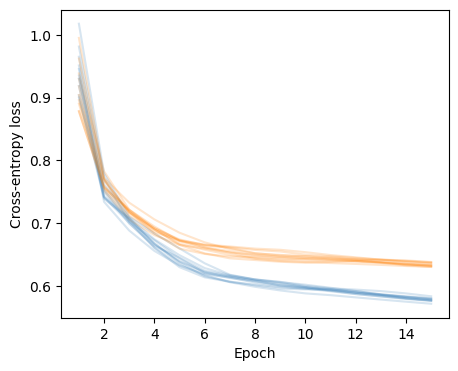

------------------------------ 
Training set:
Average log-likelihood = -4221.9 (17.6)
Average accuracy       = 75.3% (0.2%)
Average F1 score       = 72.4% (0.4%)
------------------------------ 
Validation set:
Average log-likelihood = -634.2 (2.8)
Average accuracy       = 73.9% (0.3%)
Average F1 score       = 70.8% (0.3%)
------------------------------ 
Test set:
Average log-likelihood = -1347.4 (5.1)
Average accuracy       = 72.9% (0.2%)
Average F1 score       = 69.6% (0.4%)
------------------------------ 
Training set:
Strong regularity = 0.988 (0.003)
Weak regularity   = 0.999 (0.001)
------------------------------ 
Validation set:
Strong regularity = 0.982 (0.005)
Weak regularity   = 0.999 (0.001)
------------------------------ 
Test set:
Strong regularity = 0.991 (0.003)
Weak regularity   = 0.999 (0.001)
------------------------------


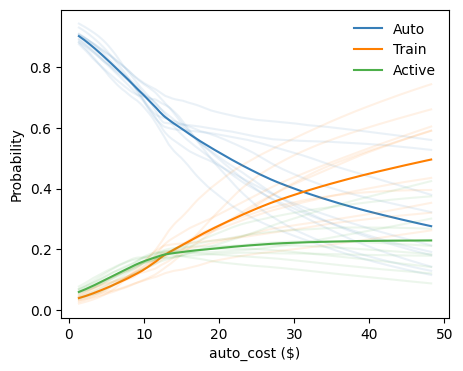

Penalty = 0.001
------------------------------
Model 1 
Training set:   LL = -4246.5 | acc = 75.6% | F1 = 72.9%
Validation set: LL = -637.9  | acc = 73.5% | F1 = 70.4%
Test set:       LL = -1341.3 | acc = 72.9% | F1 = 70.1%
Model 2 
Training set:   LL = -4265.3 | acc = 74.7% | F1 = 71.5%
Validation set: LL = -633.8  | acc = 73.9% | F1 = 70.2%
Test set:       LL = -1350.5 | acc = 73.0% | F1 = 69.3%
Model 3 
Training set:   LL = -4242.9 | acc = 75.0% | F1 = 71.8%
Validation set: LL = -638.7  | acc = 74.0% | F1 = 70.5%
Test set:       LL = -1348.7 | acc = 72.9% | F1 = 69.3%
Model 4 
Training set:   LL = -4238.0 | acc = 75.3% | F1 = 72.2%
Validation set: LL = -637.1  | acc = 73.7% | F1 = 70.0%
Test set:       LL = -1350.7 | acc = 73.0% | F1 = 69.5%
Model 5 
Training set:   LL = -4244.9 | acc = 75.0% | F1 = 72.3%
Validation set: LL = -630.4  | acc = 74.1% | F1 = 71.0%
Test set:       LL = -1351.5 | acc = 73.2% | F1 = 70.0%
Model 6 
Training set:   LL = -4257.0 | acc = 75.4% | F1 = 72.2%
Val

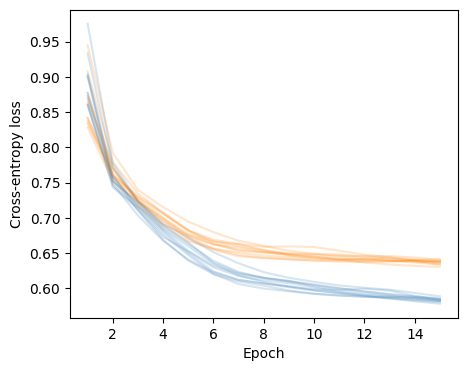

------------------------------ 
Training set:
Average log-likelihood = -4259.0 (17.7)
Average accuracy       = 75.1% (0.2%)
Average F1 score       = 72.0% (0.4%)
------------------------------ 
Validation set:
Average log-likelihood = -636.9 (3.2)
Average accuracy       = 73.8% (0.3%)
Average F1 score       = 70.3% (0.3%)
------------------------------ 
Test set:
Average log-likelihood = -1353.2 (7.9)
Average accuracy       = 72.8% (0.2%)
Average F1 score       = 69.3% (0.5%)
------------------------------ 
Training set:
Strong regularity = 0.975 (0.004)
Weak regularity   = 0.993 (0.002)
------------------------------ 
Validation set:
Strong regularity = 0.966 (0.007)
Weak regularity   = 0.992 (0.005)
------------------------------ 
Test set:
Strong regularity = 0.977 (0.005)
Weak regularity   = 0.991 (0.003)
------------------------------


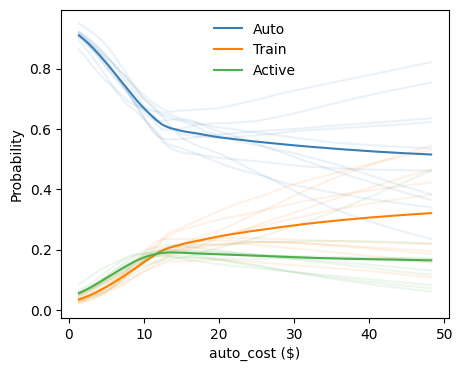

Penalty = 0.0001
------------------------------
Model 1 
Training set:   LL = -4265.5 | acc = 75.4% | F1 = 72.2%
Validation set: LL = -638.1  | acc = 74.1% | F1 = 70.6%
Test set:       LL = -1345.9 | acc = 72.9% | F1 = 69.4%
Model 2 
Training set:   LL = -4260.9 | acc = 75.1% | F1 = 72.1%
Validation set: LL = -631.4  | acc = 74.6% | F1 = 71.3%
Test set:       LL = -1348.6 | acc = 73.4% | F1 = 70.0%
Model 3 
Training set:   LL = -4274.3 | acc = 75.0% | F1 = 71.2%
Validation set: LL = -638.6  | acc = 73.8% | F1 = 69.7%
Test set:       LL = -1353.4 | acc = 72.8% | F1 = 68.6%
Model 4 
Training set:   LL = -4255.4 | acc = 75.5% | F1 = 72.2%
Validation set: LL = -637.8  | acc = 73.8% | F1 = 70.2%
Test set:       LL = -1351.2 | acc = 73.0% | F1 = 69.3%
Model 5 
Training set:   LL = -4259.9 | acc = 74.9% | F1 = 71.8%
Validation set: LL = -630.7  | acc = 73.8% | F1 = 70.4%
Test set:       LL = -1355.3 | acc = 73.0% | F1 = 69.5%
Model 6 
Training set:   LL = -4270.6 | acc = 75.4% | F1 = 72.1%
Va

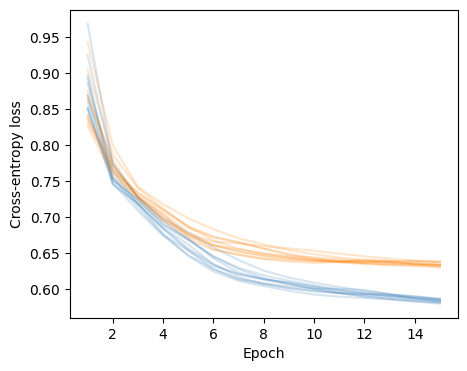

------------------------------ 
Training set:
Average log-likelihood = -4271.6 (11.9)
Average accuracy       = 75.2% (0.2%)
Average F1 score       = 71.7% (0.4%)
------------------------------ 
Validation set:
Average log-likelihood = -634.6 (2.6)
Average accuracy       = 74.0% (0.4%)
Average F1 score       = 70.3% (0.5%)
------------------------------ 
Test set:
Average log-likelihood = -1352.2 (5.2)
Average accuracy       = 72.8% (0.3%)
Average F1 score       = 69.0% (0.5%)
------------------------------ 
Training set:
Strong regularity = 0.933 (0.026)
Weak regularity   = 0.964 (0.023)
------------------------------ 
Validation set:
Strong regularity = 0.925 (0.023)
Weak regularity   = 0.967 (0.019)
------------------------------ 
Test set:
Strong regularity = 0.932 (0.028)
Weak regularity   = 0.959 (0.024)
------------------------------


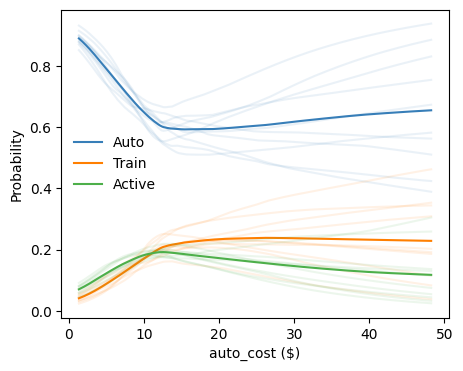

------------------------------ 
Model comparison:


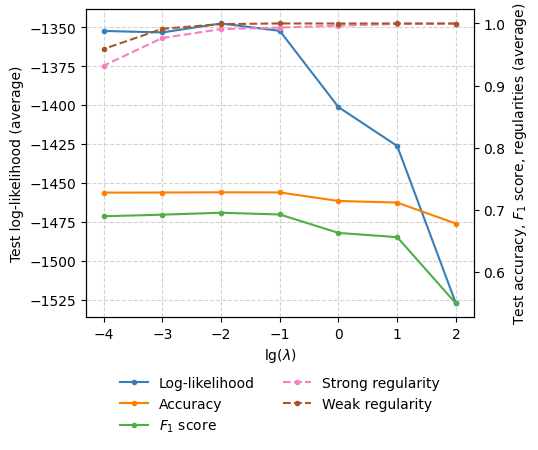

In [ ]:
# With sum
result(DNN, 15, 'LGR', [10**i for i in range(2, -5, -1)])

In [ ]:
# With norm
# result(DNN, 15, 'LGR', [10**i for i in range(2, -5, -1)], 'norm')

## TasteNet
A flexible NN-based choice model proposed by [Han et al. (2022)](https://doi.org/10.1016/j.trb.2022.07.001). Here is a special case that learns all $\beta$'s from TasteNet.

In [ ]:
class TasteNet(nn.Module):
    'Class of TasteNet'
    def __init__(self):
        super(TasteNet, self).__init__()
        self.seq = nn.Sequential(
            nn.Linear(8, 100),
            nn.ReLU(),
            nn.Linear(100, 7)
        )

    def forward(self, x):
        'Function to specify utilities using TasteNet parameters'
        betas = self.seq(x[:, :8])
        V1 = betas[:, 0] * torch.ones(len(x)) + torch.sum(betas[:, 1:3] * x[:, 8:10], dim=1)
        V2 = betas[:, 3] * torch.ones(len(x)) + torch.sum(betas[:, 4:6] * x[:, 10:12], dim=1)
        V3 = betas[:, 6] * x[:, 12]
        return torch.stack((V1, V2, V3), dim=1)

### Without GR

Penalty = 0
------------------------------
Model 1 
Training set:   LL = -4683.3 | acc = 73.2% | F1 = 67.4%
Validation set: LL = -685.0  | acc = 72.4% | F1 = 66.7%
Test set:       LL = -1439.3 | acc = 70.8% | F1 = 64.6%
Model 2 
Training set:   LL = -4679.2 | acc = 73.6% | F1 = 68.0%
Validation set: LL = -682.5  | acc = 73.1% | F1 = 67.3%
Test set:       LL = -1441.0 | acc = 71.4% | F1 = 65.5%
Model 3 
Training set:   LL = -4662.7 | acc = 73.2% | F1 = 67.6%
Validation set: LL = -681.1  | acc = 72.5% | F1 = 66.7%
Test set:       LL = -1433.2 | acc = 71.4% | F1 = 65.4%
Model 4 
Training set:   LL = -4683.9 | acc = 73.2% | F1 = 67.3%
Validation set: LL = -688.0  | acc = 72.4% | F1 = 66.2%
Test set:       LL = -1440.0 | acc = 71.0% | F1 = 64.8%
Model 5 
Training set:   LL = -4703.7 | acc = 73.1% | F1 = 67.2%
Validation set: LL = -679.7  | acc = 72.6% | F1 = 66.6%
Test set:       LL = -1438.2 | acc = 71.7% | F1 = 65.8%
Model 6 
Training set:   LL = -4689.6 | acc = 73.2% | F1 = 67.4%
Validat

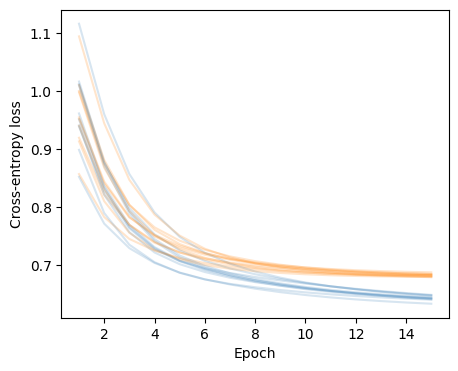

------------------------------ 
Training set:
Average log-likelihood = -4677.8 (19.9)
Average accuracy       = 73.2% (0.2%)
Average F1 score       = 67.5% (0.4%)
------------------------------ 
Validation set:
Average log-likelihood = -683.0 (2.4)
Average accuracy       = 72.6% (0.4%)
Average F1 score       = 66.8% (0.7%)
------------------------------ 
Test set:
Average log-likelihood = -1438.3 (5.8)
Average accuracy       = 71.3% (0.3%)
Average F1 score       = 65.4% (0.6%)
------------------------------ 
Training set:
Strong regularity = 0.997 (0.003)
Weak regularity   = 0.999 (0.002)
------------------------------ 
Validation set:
Strong regularity = 0.997 (0.005)
Weak regularity   = 0.998 (0.003)
------------------------------ 
Test set:
Strong regularity = 0.998 (0.002)
Weak regularity   = 0.999 (0.002)
------------------------------


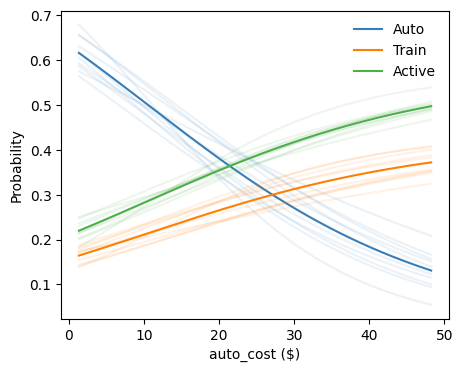

In [ ]:
result(TasteNet, 15, 'none')

### PGR

Penalty = 10
------------------------------
Model 1 
Training set:   LL = -8897.6 | acc = 27.0% | F1 = 30.1%
Validation set: LL = -1276.2 | acc = 26.2% | F1 = 29.8%
Test set:       LL = -2532.3 | acc = 27.1% | F1 = 30.4%
Model 2 
Training set:   LL = -7476.5 | acc = 41.6% | F1 = 45.5%
Validation set: LL = -1066.3 | acc = 40.7% | F1 = 44.8%
Test set:       LL = -2112.5 | acc = 43.7% | F1 = 47.3%
Model 3 
Training set:   LL = -9387.0 | acc = 24.8% | F1 = 27.9%
Validation set: LL = -1336.0 | acc = 24.9% | F1 = 28.7%
Test set:       LL = -2650.7 | acc = 27.2% | F1 = 30.5%
Model 4 
Training set:   LL = -6326.8 | acc = 62.5% | F1 = 55.8%
Validation set: LL = -916.1  | acc = 62.6% | F1 = 56.2%
Test set:       LL = -1822.6 | acc = 62.2% | F1 = 55.0%
Model 5 
Training set:   LL = -6432.9 | acc = 57.4% | F1 = 54.3%
Validation set: LL = -906.6  | acc = 56.7% | F1 = 54.0%
Test set:       LL = -1849.7 | acc = 56.6% | F1 = 53.2%
Model 6 
Training set:   LL = -7698.2 | acc = 45.1% | F1 = 47.1%
Valida

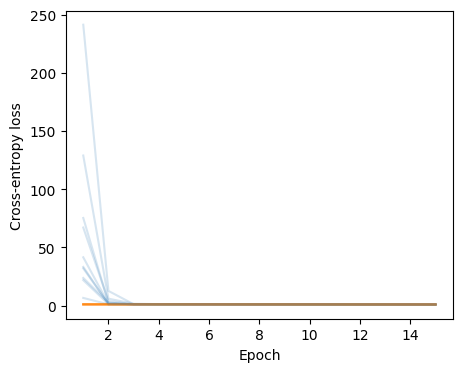

------------------------------ 
Training set:
Average log-likelihood = -7512.3 (1080.0)
Average accuracy       = 45.7% (14.0%)
Average F1 score       = 45.6% (10.4%)
------------------------------ 
Validation set:
Average log-likelihood = -1075.1 (156.1)
Average accuracy       = 45.0% (14.2%)
Average F1 score       = 45.3% (10.4%)
------------------------------ 
Test set:
Average log-likelihood = -2145.4 (297.9)
Average accuracy       = 45.9% (13.3%)
Average F1 score       = 45.5% (9.6%)
------------------------------ 
Training set:
Strong regularity = 1.000 (0.000)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Validation set:
Strong regularity = 1.000 (0.000)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Test set:
Strong regularity = 1.000 (0.000)
Weak regularity   = 1.000 (0.000)
------------------------------


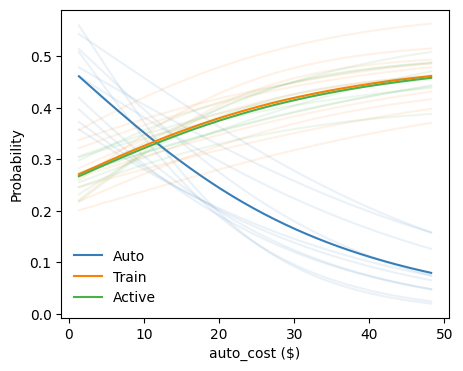

Penalty = 1
------------------------------
Model 1 
Training set:   LL = -6260.6 | acc = 64.3% | F1 = 57.6%
Validation set: LL = -898.7  | acc = 62.9% | F1 = 56.3%
Test set:       LL = -1818.2 | acc = 62.6% | F1 = 55.4%
Model 2 
Training set:   LL = -5494.2 | acc = 67.6% | F1 = 56.8%
Validation set: LL = -781.7  | acc = 68.0% | F1 = 57.0%
Test set:       LL = -1602.0 | acc = 66.2% | F1 = 54.7%
Model 3 
Training set:   LL = -7718.0 | acc = 39.2% | F1 = 41.7%
Validation set: LL = -1088.8 | acc = 40.6% | F1 = 42.9%
Test set:       LL = -2194.5 | acc = 40.5% | F1 = 42.7%
Model 4 
Training set:   LL = -5506.8 | acc = 69.0% | F1 = 56.8%
Validation set: LL = -790.4  | acc = 68.9% | F1 = 56.9%
Test set:       LL = -1622.3 | acc = 67.3% | F1 = 54.7%
Model 5 
Training set:   LL = -5335.5 | acc = 69.4% | F1 = 57.3%
Validation set: LL = -748.3  | acc = 69.8% | F1 = 57.7%
Test set:       LL = -1592.2 | acc = 67.8% | F1 = 55.3%
Model 6 
Training set:   LL = -5957.8 | acc = 62.8% | F1 = 54.7%
Validat

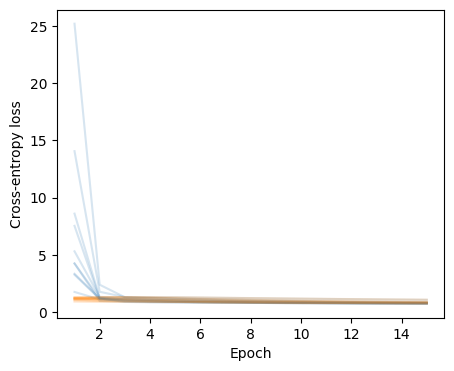

------------------------------ 
Training set:
Average log-likelihood = -5894.4 (668.6)
Average accuracy       = 64.4% (8.6%)
Average F1 score       = 56.3% (5.4%)
------------------------------ 
Validation set:
Average log-likelihood = -838.6 (94.1)
Average accuracy       = 64.3% (8.3%)
Average F1 score       = 56.4% (4.9%)
------------------------------ 
Test set:
Average log-likelihood = -1723.6 (171.9)
Average accuracy       = 63.1% (7.8%)
Average F1 score       = 54.6% (4.5%)
------------------------------ 
Training set:
Strong regularity = 1.000 (0.000)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Validation set:
Strong regularity = 1.000 (0.000)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Test set:
Strong regularity = 1.000 (0.000)
Weak regularity   = 1.000 (0.000)
------------------------------


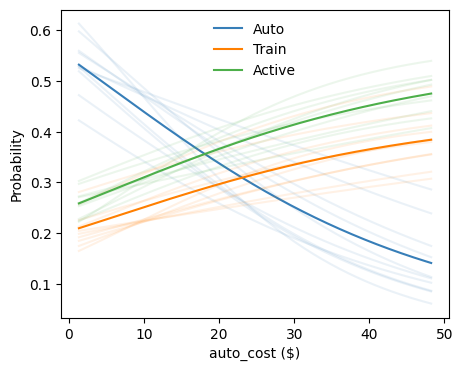

Penalty = 0.1
------------------------------
Model 1 
Training set:   LL = -5210.1 | acc = 70.1% | F1 = 59.4%
Validation set: LL = -742.7  | acc = 70.3% | F1 = 59.2%
Test set:       LL = -1571.0 | acc = 68.0% | F1 = 56.5%
Model 2 
Training set:   LL = -4941.0 | acc = 72.1% | F1 = 64.2%
Validation set: LL = -706.1  | acc = 72.1% | F1 = 64.0%
Test set:       LL = -1493.9 | acc = 70.3% | F1 = 62.2%
Model 3 
Training set:   LL = -5355.3 | acc = 69.5% | F1 = 57.5%
Validation set: LL = -760.3  | acc = 69.8% | F1 = 57.7%
Test set:       LL = -1598.9 | acc = 67.7% | F1 = 55.3%
Model 4 
Training set:   LL = -5068.1 | acc = 70.7% | F1 = 60.2%
Validation set: LL = -729.3  | acc = 70.9% | F1 = 60.1%
Test set:       LL = -1535.6 | acc = 69.0% | F1 = 58.6%
Model 5 
Training set:   LL = -5033.9 | acc = 71.9% | F1 = 64.0%
Validation set: LL = -710.5  | acc = 71.6% | F1 = 63.2%
Test set:       LL = -1525.8 | acc = 69.8% | F1 = 61.9%
Model 6 
Training set:   LL = -5149.6 | acc = 70.0% | F1 = 58.8%
Valid

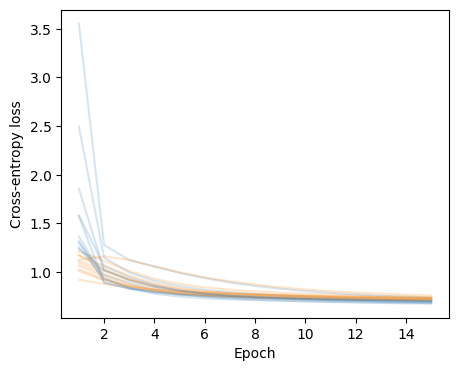

------------------------------ 
Training set:
Average log-likelihood = -5102.6 (115.3)
Average accuracy       = 70.8% (0.9%)
Average F1 score       = 60.9% (2.5%)
------------------------------ 
Validation set:
Average log-likelihood = -727.5 (15.8)
Average accuracy       = 70.8% (0.7%)
Average F1 score       = 60.7% (2.2%)
------------------------------ 
Test set:
Average log-likelihood = -1539.7 (29.1)
Average accuracy       = 68.8% (0.9%)
Average F1 score       = 58.5% (2.7%)
------------------------------ 
Training set:
Strong regularity = 0.997 (0.005)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Validation set:
Strong regularity = 0.997 (0.004)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Test set:
Strong regularity = 0.997 (0.006)
Weak regularity   = 1.000 (0.001)
------------------------------


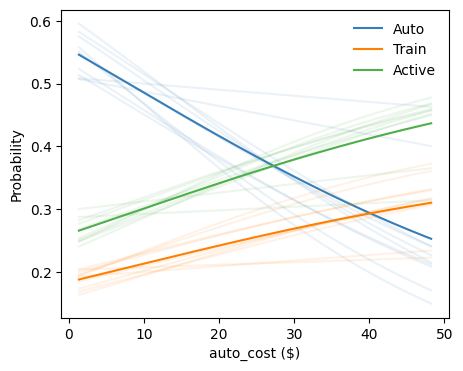

Penalty = 0.01
------------------------------
Model 1 
Training set:   LL = -4859.2 | acc = 72.4% | F1 = 65.2%
Validation set: LL = -696.5  | acc = 71.6% | F1 = 64.5%
Test set:       LL = -1490.6 | acc = 70.1% | F1 = 62.8%
Model 2 
Training set:   LL = -4762.2 | acc = 72.7% | F1 = 66.1%
Validation set: LL = -686.7  | acc = 71.8% | F1 = 65.1%
Test set:       LL = -1457.9 | acc = 70.8% | F1 = 64.0%
Model 3 
Training set:   LL = -4836.9 | acc = 72.3% | F1 = 65.1%
Validation set: LL = -693.4  | acc = 71.8% | F1 = 64.5%
Test set:       LL = -1481.7 | acc = 70.5% | F1 = 63.2%
Model 4 
Training set:   LL = -4811.7 | acc = 72.4% | F1 = 65.1%
Validation set: LL = -697.3  | acc = 71.7% | F1 = 64.5%
Test set:       LL = -1473.6 | acc = 70.2% | F1 = 62.8%
Model 5 
Training set:   LL = -4784.3 | acc = 72.6% | F1 = 66.1%
Validation set: LL = -685.0  | acc = 71.9% | F1 = 65.2%
Test set:       LL = -1464.3 | acc = 71.1% | F1 = 64.5%
Model 6 
Training set:   LL = -4836.7 | acc = 72.6% | F1 = 65.9%
Vali

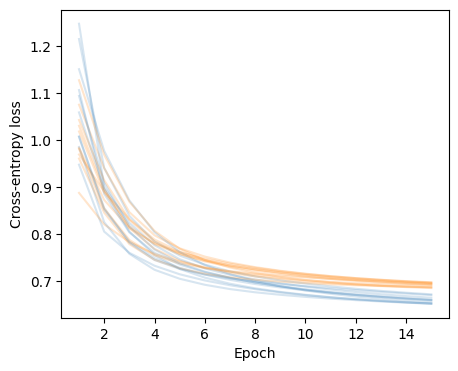

------------------------------ 
Training set:
Average log-likelihood = -4806.6 (36.7)
Average accuracy       = 72.5% (0.3%)
Average F1 score       = 65.7% (0.7%)
------------------------------ 
Validation set:
Average log-likelihood = -691.8 (4.3)
Average accuracy       = 71.8% (0.3%)
Average F1 score       = 64.9% (0.7%)
------------------------------ 
Test set:
Average log-likelihood = -1473.0 (11.8)
Average accuracy       = 70.7% (0.5%)
Average F1 score       = 63.7% (1.0%)
------------------------------ 
Training set:
Strong regularity = 0.999 (0.001)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Validation set:
Strong regularity = 0.999 (0.001)
Weak regularity   = 1.000 (0.001)
------------------------------ 
Test set:
Strong regularity = 0.999 (0.001)
Weak regularity   = 1.000 (0.001)
------------------------------


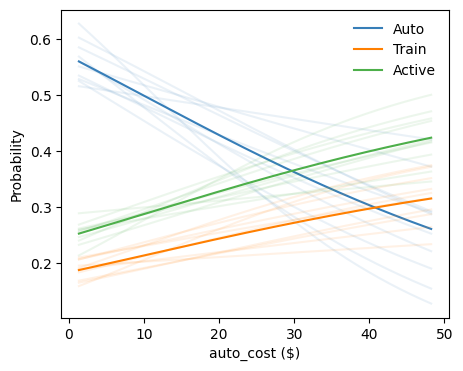

Penalty = 0.001
------------------------------
Model 1 
Training set:   LL = -4705.1 | acc = 73.2% | F1 = 67.2%
Validation set: LL = -684.8  | acc = 72.0% | F1 = 65.9%
Test set:       LL = -1447.5 | acc = 71.0% | F1 = 64.7%
Model 2 
Training set:   LL = -4689.4 | acc = 73.4% | F1 = 67.7%
Validation set: LL = -682.1  | acc = 72.8% | F1 = 66.9%
Test set:       LL = -1443.5 | acc = 71.5% | F1 = 65.5%
Model 3 
Training set:   LL = -4689.6 | acc = 73.2% | F1 = 67.3%
Validation set: LL = -681.3  | acc = 71.7% | F1 = 65.4%
Test set:       LL = -1441.6 | acc = 71.0% | F1 = 64.9%
Model 4 
Training set:   LL = -4698.5 | acc = 73.1% | F1 = 67.1%
Validation set: LL = -689.2  | acc = 72.0% | F1 = 65.6%
Test set:       LL = -1444.2 | acc = 71.1% | F1 = 64.9%
Model 5 
Training set:   LL = -4705.4 | acc = 73.0% | F1 = 67.1%
Validation set: LL = -680.1  | acc = 72.4% | F1 = 66.2%
Test set:       LL = -1441.4 | acc = 71.5% | F1 = 65.6%
Model 6 
Training set:   LL = -4700.4 | acc = 73.1% | F1 = 67.1%
Val

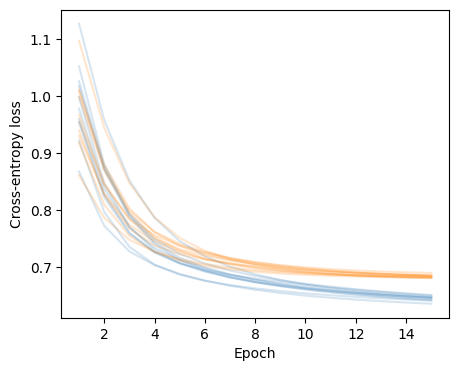

------------------------------ 
Training set:
Average log-likelihood = -4691.4 (17.5)
Average accuracy       = 73.2% (0.2%)
Average F1 score       = 67.3% (0.4%)
------------------------------ 
Validation set:
Average log-likelihood = -683.4 (2.6)
Average accuracy       = 72.4% (0.4%)
Average F1 score       = 66.4% (0.6%)
------------------------------ 
Test set:
Average log-likelihood = -1443.8 (5.7)
Average accuracy       = 71.3% (0.2%)
Average F1 score       = 65.2% (0.5%)
------------------------------ 
Training set:
Strong regularity = 0.999 (0.000)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Validation set:
Strong regularity = 1.000 (0.001)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Test set:
Strong regularity = 1.000 (0.001)
Weak regularity   = 1.000 (0.000)
------------------------------


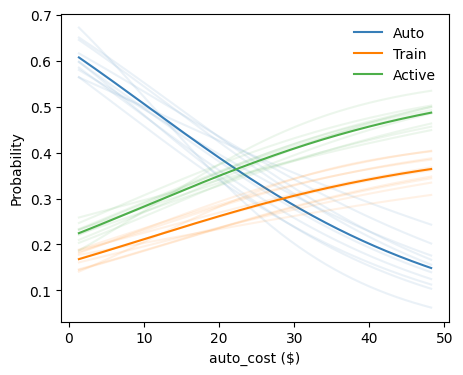

Penalty = 0.0001
------------------------------
Model 1 
Training set:   LL = -4680.4 | acc = 73.2% | F1 = 67.4%
Validation set: LL = -684.7  | acc = 72.6% | F1 = 66.8%
Test set:       LL = -1438.8 | acc = 70.9% | F1 = 64.7%
Model 2 
Training set:   LL = -4678.9 | acc = 73.7% | F1 = 68.1%
Validation set: LL = -682.5  | acc = 73.0% | F1 = 67.3%
Test set:       LL = -1441.1 | acc = 71.4% | F1 = 65.6%
Model 3 
Training set:   LL = -4662.6 | acc = 73.2% | F1 = 67.6%
Validation set: LL = -681.1  | acc = 72.6% | F1 = 66.8%
Test set:       LL = -1433.4 | acc = 71.2% | F1 = 65.2%
Model 4 
Training set:   LL = -4683.4 | acc = 73.1% | F1 = 67.3%
Validation set: LL = -688.3  | acc = 72.3% | F1 = 66.1%
Test set:       LL = -1440.6 | acc = 71.0% | F1 = 64.9%
Model 5 
Training set:   LL = -4700.0 | acc = 73.0% | F1 = 67.1%
Validation set: LL = -679.8  | acc = 72.6% | F1 = 66.6%
Test set:       LL = -1438.2 | acc = 71.5% | F1 = 65.7%
Model 6 
Training set:   LL = -4684.6 | acc = 73.1% | F1 = 67.3%
Va

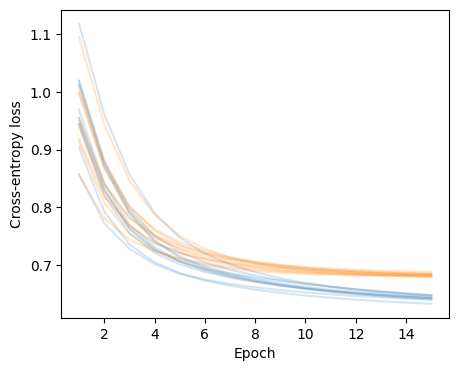

------------------------------ 
Training set:
Average log-likelihood = -4675.8 (19.4)
Average accuracy       = 73.2% (0.2%)
Average F1 score       = 67.5% (0.4%)
------------------------------ 
Validation set:
Average log-likelihood = -683.1 (2.5)
Average accuracy       = 72.7% (0.3%)
Average F1 score       = 66.9% (0.6%)
------------------------------ 
Test set:
Average log-likelihood = -1438.4 (6.0)
Average accuracy       = 71.3% (0.2%)
Average F1 score       = 65.4% (0.5%)
------------------------------ 
Training set:
Strong regularity = 0.998 (0.002)
Weak regularity   = 0.999 (0.001)
------------------------------ 
Validation set:
Strong regularity = 0.999 (0.002)
Weak regularity   = 0.999 (0.002)
------------------------------ 
Test set:
Strong regularity = 0.999 (0.001)
Weak regularity   = 1.000 (0.001)
------------------------------


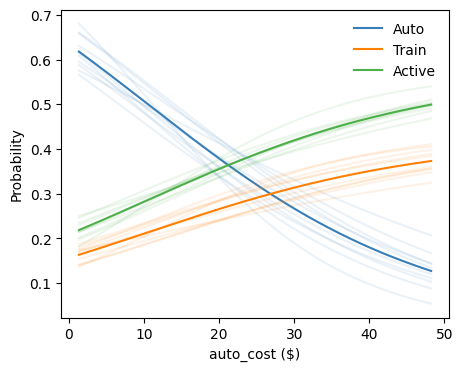

Penalty = 1e-05
------------------------------
Model 1 
Training set:   LL = -4682.7 | acc = 73.2% | F1 = 67.4%
Validation set: LL = -684.9  | acc = 72.4% | F1 = 66.7%
Test set:       LL = -1439.2 | acc = 70.9% | F1 = 64.7%
Model 2 
Training set:   LL = -4679.1 | acc = 73.6% | F1 = 68.0%
Validation set: LL = -682.5  | acc = 73.0% | F1 = 67.2%
Test set:       LL = -1441.0 | acc = 71.4% | F1 = 65.5%
Model 3 
Training set:   LL = -4662.6 | acc = 73.2% | F1 = 67.6%
Validation set: LL = -681.1  | acc = 72.5% | F1 = 66.7%
Test set:       LL = -1433.2 | acc = 71.4% | F1 = 65.4%
Model 4 
Training set:   LL = -4683.7 | acc = 73.2% | F1 = 67.3%
Validation set: LL = -688.0  | acc = 72.4% | F1 = 66.2%
Test set:       LL = -1440.1 | acc = 71.0% | F1 = 64.8%
Model 5 
Training set:   LL = -4703.0 | acc = 73.0% | F1 = 67.2%
Validation set: LL = -679.7  | acc = 72.6% | F1 = 66.6%
Test set:       LL = -1438.1 | acc = 71.6% | F1 = 65.8%
Model 6 
Training set:   LL = -4688.8 | acc = 73.1% | F1 = 67.3%
Val

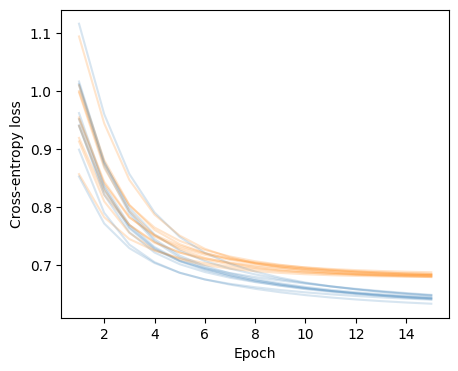

------------------------------ 
Training set:
Average log-likelihood = -4677.4 (19.8)
Average accuracy       = 73.2% (0.2%)
Average F1 score       = 67.5% (0.4%)
------------------------------ 
Validation set:
Average log-likelihood = -683.0 (2.4)
Average accuracy       = 72.6% (0.4%)
Average F1 score       = 66.9% (0.7%)
------------------------------ 
Test set:
Average log-likelihood = -1438.2 (5.9)
Average accuracy       = 71.3% (0.3%)
Average F1 score       = 65.4% (0.5%)
------------------------------ 
Training set:
Strong regularity = 0.998 (0.002)
Weak regularity   = 0.999 (0.002)
------------------------------ 
Validation set:
Strong regularity = 0.997 (0.004)
Weak regularity   = 0.998 (0.003)
------------------------------ 
Test set:
Strong regularity = 0.998 (0.002)
Weak regularity   = 0.999 (0.002)
------------------------------


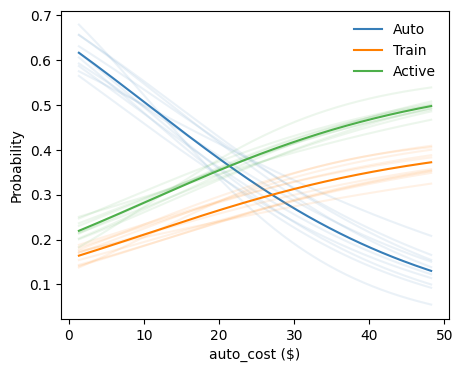

------------------------------ 
Model comparison:


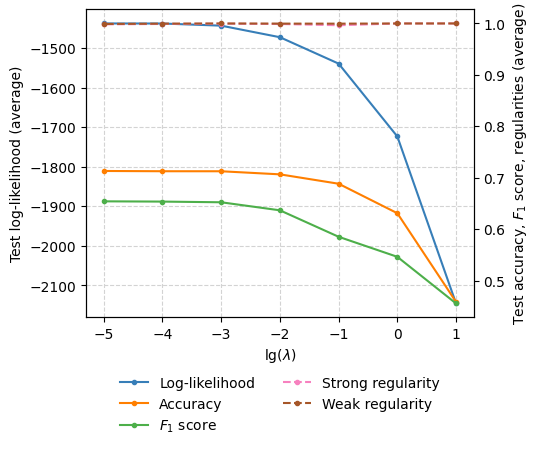

In [ ]:
# With sum
result(TasteNet, 15, 'PGR', [10**i for i in range(1, -6, -1)])

In [ ]:
# With norm
# result(TasteNet, 15, 'PGR', [10**i for i in range(1, -6, -1)], 'norm')

### UGR

Penalty = 10
------------------------------
Model 1 
Training set:   LL = -5740.2 | acc = 65.3% | F1 = 56.8%
Validation set: LL = -817.8  | acc = 65.1% | F1 = 57.1%
Test set:       LL = -1703.5 | acc = 63.5% | F1 = 54.8%
Model 2 
Training set:   LL = -5360.9 | acc = 67.1% | F1 = 56.8%
Validation set: LL = -757.6  | acc = 67.3% | F1 = 57.6%
Test set:       LL = -1591.4 | acc = 65.4% | F1 = 54.6%
Model 3 
Training set:   LL = -5637.7 | acc = 65.4% | F1 = 57.2%
Validation set: LL = -803.7  | acc = 65.2% | F1 = 57.8%
Test set:       LL = -1689.5 | acc = 63.2% | F1 = 54.6%
Model 4 
Training set:   LL = -5316.3 | acc = 68.6% | F1 = 57.1%
Validation set: LL = -762.0  | acc = 68.2% | F1 = 56.8%
Test set:       LL = -1593.5 | acc = 66.6% | F1 = 55.0%
Model 5 
Training set:   LL = -5409.6 | acc = 68.8% | F1 = 57.1%
Validation set: LL = -756.1  | acc = 69.1% | F1 = 57.2%
Test set:       LL = -1607.3 | acc = 67.2% | F1 = 55.1%
Model 6 
Training set:   LL = -5548.8 | acc = 66.0% | F1 = 56.2%
Valida

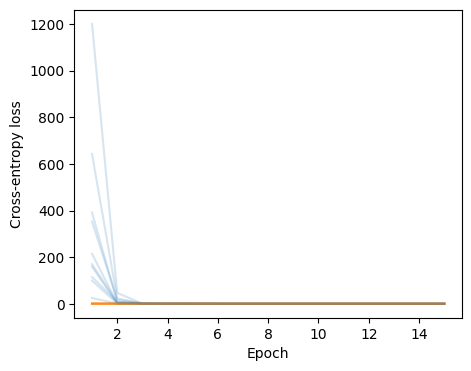

------------------------------ 
Training set:
Average log-likelihood = -5474.5 (126.5)
Average accuracy       = 67.3% (1.3%)
Average F1 score       = 57.5% (1.1%)
------------------------------ 
Validation set:
Average log-likelihood = -778.1 (19.5)
Average accuracy       = 67.3% (1.3%)
Average F1 score       = 57.8% (1.0%)
------------------------------ 
Test set:
Average log-likelihood = -1633.8 (37.5)
Average accuracy       = 65.4% (1.3%)
Average F1 score       = 55.2% (0.8%)
------------------------------ 
Training set:
Strong regularity = 1.000 (0.000)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Validation set:
Strong regularity = 1.000 (0.000)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Test set:
Strong regularity = 1.000 (0.000)
Weak regularity   = 1.000 (0.000)
------------------------------


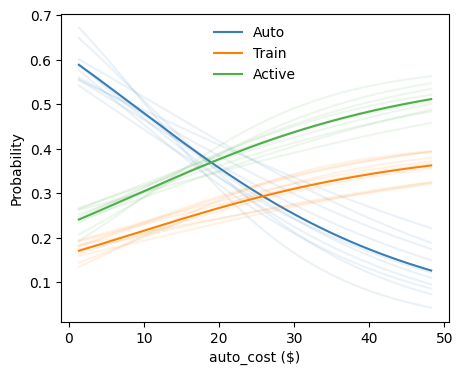

Penalty = 1
------------------------------
Model 1 
Training set:   LL = -5687.2 | acc = 65.8% | F1 = 57.0%
Validation set: LL = -809.7  | acc = 65.5% | F1 = 57.2%
Test set:       LL = -1689.9 | acc = 64.1% | F1 = 55.0%
Model 2 
Training set:   LL = -5284.1 | acc = 67.9% | F1 = 57.3%
Validation set: LL = -746.6  | acc = 68.5% | F1 = 58.8%
Test set:       LL = -1570.7 | acc = 66.0% | F1 = 55.0%
Model 3 
Training set:   LL = -5616.3 | acc = 65.5% | F1 = 57.2%
Validation set: LL = -800.4  | acc = 65.3% | F1 = 57.8%
Test set:       LL = -1683.7 | acc = 63.3% | F1 = 54.6%
Model 4 
Training set:   LL = -5270.5 | acc = 69.0% | F1 = 57.2%
Validation set: LL = -754.8  | acc = 68.4% | F1 = 56.7%
Test set:       LL = -1582.7 | acc = 67.0% | F1 = 54.8%
Model 5 
Training set:   LL = -5326.9 | acc = 69.6% | F1 = 58.0%
Validation set: LL = -745.3  | acc = 69.7% | F1 = 57.8%
Test set:       LL = -1590.0 | acc = 68.0% | F1 = 55.9%
Model 6 
Training set:   LL = -5414.3 | acc = 67.6% | F1 = 56.7%
Validat

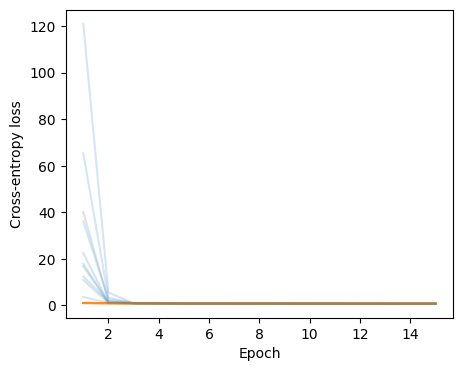

------------------------------ 
Training set:
Average log-likelihood = -5400.3 (137.5)
Average accuracy       = 68.1% (1.4%)
Average F1 score       = 57.9% (1.2%)
------------------------------ 
Validation set:
Average log-likelihood = -767.6 (20.6)
Average accuracy       = 68.0% (1.4%)
Average F1 score       = 58.2% (1.2%)
------------------------------ 
Test set:
Average log-likelihood = -1615.3 (40.3)
Average accuracy       = 66.2% (1.4%)
Average F1 score       = 55.6% (1.1%)
------------------------------ 
Training set:
Strong regularity = 1.000 (0.001)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Validation set:
Strong regularity = 1.000 (0.001)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Test set:
Strong regularity = 1.000 (0.002)
Weak regularity   = 1.000 (0.000)
------------------------------


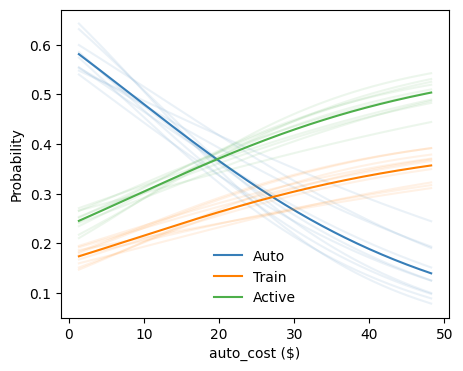

Penalty = 0.1
------------------------------
Model 1 
Training set:   LL = -5399.1 | acc = 68.9% | F1 = 58.7%
Validation set: LL = -767.0  | acc = 69.4% | F1 = 59.1%
Test set:       LL = -1618.6 | acc = 67.1% | F1 = 56.2%
Model 2 
Training set:   LL = -5052.3 | acc = 71.0% | F1 = 61.7%
Validation set: LL = -717.0  | acc = 70.5% | F1 = 60.8%
Test set:       LL = -1512.1 | acc = 68.9% | F1 = 59.4%
Model 3 
Training set:   LL = -5441.6 | acc = 67.1% | F1 = 57.7%
Validation set: LL = -773.8  | acc = 67.0% | F1 = 57.9%
Test set:       LL = -1636.5 | acc = 65.0% | F1 = 55.0%
Model 4 
Training set:   LL = -5129.8 | acc = 69.6% | F1 = 57.9%
Validation set: LL = -735.7  | acc = 70.2% | F1 = 58.6%
Test set:       LL = -1552.8 | acc = 68.2% | F1 = 56.3%
Model 5 
Training set:   LL = -5182.2 | acc = 70.6% | F1 = 60.6%
Validation set: LL = -727.9  | acc = 70.7% | F1 = 60.2%
Test set:       LL = -1557.3 | acc = 69.3% | F1 = 59.2%
Model 6 
Training set:   LL = -5218.7 | acc = 69.4% | F1 = 57.3%
Valid

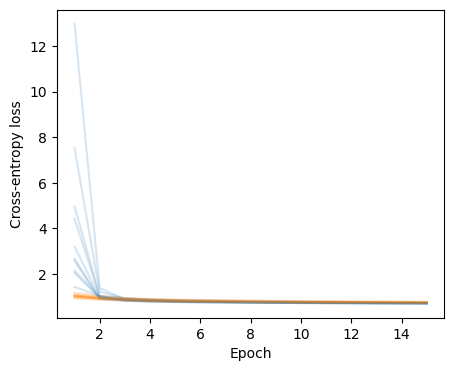

------------------------------ 
Training set:
Average log-likelihood = -5218.0 (116.2)
Average accuracy       = 69.7% (1.1%)
Average F1 score       = 59.4% (1.8%)
------------------------------ 
Validation set:
Average log-likelihood = -742.3 (16.3)
Average accuracy       = 69.8% (1.0%)
Average F1 score       = 59.5% (1.5%)
------------------------------ 
Test set:
Average log-likelihood = -1570.3 (34.8)
Average accuracy       = 67.9% (1.2%)
Average F1 score       = 57.2% (1.7%)
------------------------------ 
Training set:
Strong regularity = 0.998 (0.004)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Validation set:
Strong regularity = 0.999 (0.003)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Test set:
Strong regularity = 0.998 (0.004)
Weak regularity   = 1.000 (0.000)
------------------------------


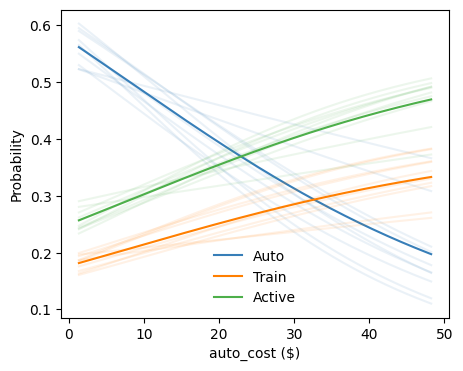

Penalty = 0.01
------------------------------
Model 1 
Training set:   LL = -5039.5 | acc = 71.1% | F1 = 62.2%
Validation set: LL = -718.3  | acc = 71.3% | F1 = 62.5%
Test set:       LL = -1532.7 | acc = 69.0% | F1 = 59.3%
Model 2 
Training set:   LL = -4869.9 | acc = 72.4% | F1 = 65.1%
Validation set: LL = -698.2  | acc = 72.1% | F1 = 64.8%
Test set:       LL = -1480.5 | acc = 70.5% | F1 = 63.1%
Model 3 
Training set:   LL = -5026.3 | acc = 71.1% | F1 = 62.4%
Validation set: LL = -715.8  | acc = 71.4% | F1 = 62.7%
Test set:       LL = -1531.0 | acc = 69.1% | F1 = 59.8%
Model 4 
Training set:   LL = -4957.5 | acc = 71.3% | F1 = 62.6%
Validation set: LL = -715.0  | acc = 70.8% | F1 = 62.0%
Test set:       LL = -1512.7 | acc = 69.5% | F1 = 60.6%
Model 5 
Training set:   LL = -4931.0 | acc = 72.2% | F1 = 65.0%
Validation set: LL = -698.8  | acc = 71.2% | F1 = 63.8%
Test set:       LL = -1502.4 | acc = 70.8% | F1 = 63.6%
Model 6 
Training set:   LL = -5016.2 | acc = 71.5% | F1 = 63.1%
Vali

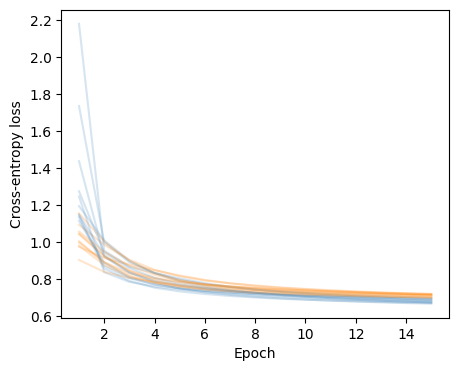

------------------------------ 
Training set:
Average log-likelihood = -4962.2 (57.2)
Average accuracy       = 71.7% (0.5%)
Average F1 score       = 63.6% (1.3%)
------------------------------ 
Validation set:
Average log-likelihood = -709.5 (7.5)
Average accuracy       = 71.2% (0.4%)
Average F1 score       = 63.0% (1.1%)
------------------------------ 
Test set:
Average log-likelihood = -1510.1 (17.2)
Average accuracy       = 69.7% (0.7%)
Average F1 score       = 61.2% (1.7%)
------------------------------ 
Training set:
Strong regularity = 0.996 (0.005)
Weak regularity   = 1.000 (0.001)
------------------------------ 
Validation set:
Strong regularity = 0.997 (0.003)
Weak regularity   = 1.000 (0.001)
------------------------------ 
Test set:
Strong regularity = 0.997 (0.005)
Weak regularity   = 1.000 (0.001)
------------------------------


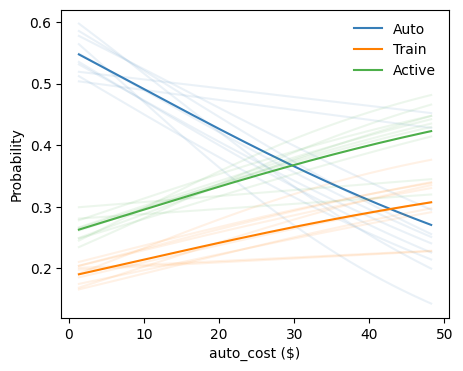

Penalty = 0.001
------------------------------
Model 1 
Training set:   LL = -4793.6 | acc = 72.9% | F1 = 66.3%
Validation set: LL = -690.3  | acc = 71.8% | F1 = 65.4%
Test set:       LL = -1474.4 | acc = 70.5% | F1 = 63.8%
Model 2 
Training set:   LL = -4725.6 | acc = 72.9% | F1 = 66.8%
Validation set: LL = -683.7  | acc = 72.3% | F1 = 65.9%
Test set:       LL = -1450.2 | acc = 70.9% | F1 = 64.2%
Model 3 
Training set:   LL = -4772.6 | acc = 72.8% | F1 = 66.3%
Validation set: LL = -687.1  | acc = 71.7% | F1 = 65.2%
Test set:       LL = -1464.1 | acc = 70.6% | F1 = 63.9%
Model 4 
Training set:   LL = -4755.9 | acc = 72.6% | F1 = 66.0%
Validation set: LL = -692.1  | acc = 71.8% | F1 = 64.9%
Test set:       LL = -1460.3 | acc = 70.4% | F1 = 63.5%
Model 5 
Training set:   LL = -4739.7 | acc = 72.9% | F1 = 66.6%
Validation set: LL = -681.7  | acc = 71.9% | F1 = 65.4%
Test set:       LL = -1452.7 | acc = 71.5% | F1 = 65.2%
Model 6 
Training set:   LL = -4775.8 | acc = 72.8% | F1 = 66.4%
Val

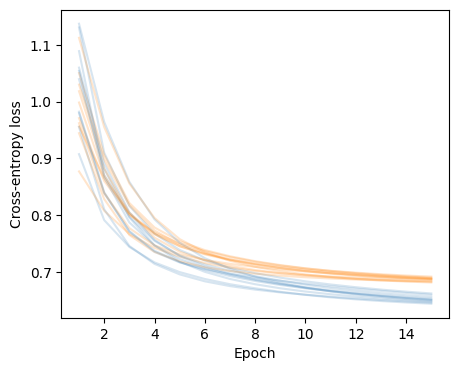

------------------------------ 
Training set:
Average log-likelihood = -4753.5 (26.5)
Average accuracy       = 72.8% (0.2%)
Average F1 score       = 66.5% (0.4%)
------------------------------ 
Validation set:
Average log-likelihood = -687.0 (3.1)
Average accuracy       = 72.0% (0.3%)
Average F1 score       = 65.5% (0.5%)
------------------------------ 
Test set:
Average log-likelihood = -1460.4 (8.8)
Average accuracy       = 70.9% (0.4%)
Average F1 score       = 64.3% (0.8%)
------------------------------ 
Training set:
Strong regularity = 1.000 (0.000)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Validation set:
Strong regularity = 1.000 (0.000)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Test set:
Strong regularity = 0.999 (0.001)
Weak regularity   = 1.000 (0.001)
------------------------------


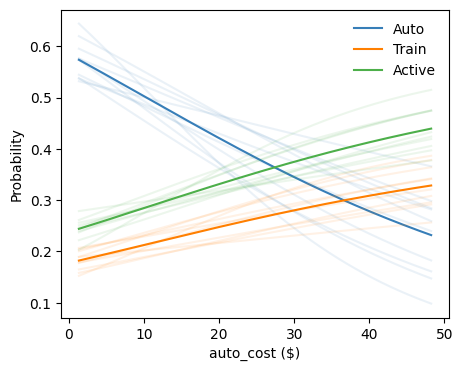

Penalty = 0.0001
------------------------------
Model 1 
Training set:   LL = -4688.8 | acc = 73.2% | F1 = 67.3%
Validation set: LL = -684.5  | acc = 72.6% | F1 = 66.7%
Test set:       LL = -1442.7 | acc = 71.1% | F1 = 64.8%
Model 2 
Training set:   LL = -4683.7 | acc = 73.5% | F1 = 67.9%
Validation set: LL = -682.2  | acc = 72.8% | F1 = 67.1%
Test set:       LL = -1442.7 | acc = 71.3% | F1 = 65.4%
Model 3 
Training set:   LL = -4673.3 | acc = 73.2% | F1 = 67.4%
Validation set: LL = -681.1  | acc = 71.9% | F1 = 65.8%
Test set:       LL = -1436.9 | acc = 71.4% | F1 = 65.4%
Model 4 
Training set:   LL = -4689.3 | acc = 73.1% | F1 = 67.2%
Validation set: LL = -688.8  | acc = 72.2% | F1 = 65.9%
Test set:       LL = -1442.2 | acc = 71.1% | F1 = 65.0%
Model 5 
Training set:   LL = -4700.7 | acc = 73.0% | F1 = 67.2%
Validation set: LL = -679.8  | acc = 72.5% | F1 = 66.4%
Test set:       LL = -1440.4 | acc = 71.5% | F1 = 65.6%
Model 6 
Training set:   LL = -4688.5 | acc = 73.1% | F1 = 67.2%
Va

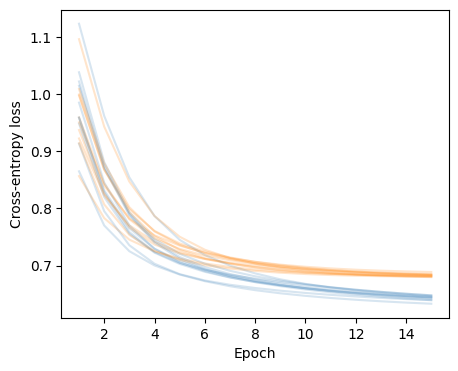

------------------------------ 
Training set:
Average log-likelihood = -4681.1 (18.1)
Average accuracy       = 73.2% (0.2%)
Average F1 score       = 67.4% (0.4%)
------------------------------ 
Validation set:
Average log-likelihood = -683.1 (2.6)
Average accuracy       = 72.5% (0.3%)
Average F1 score       = 66.6% (0.6%)
------------------------------ 
Test set:
Average log-likelihood = -1441.1 (5.7)
Average accuracy       = 71.3% (0.2%)
Average F1 score       = 65.4% (0.4%)
------------------------------ 
Training set:
Strong regularity = 0.999 (0.001)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Validation set:
Strong regularity = 0.999 (0.001)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Test set:
Strong regularity = 1.000 (0.001)
Weak regularity   = 1.000 (0.000)
------------------------------


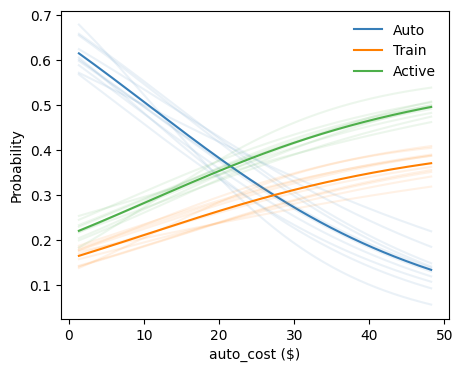

Penalty = 1e-05
------------------------------
Model 1 
Training set:   LL = -4680.6 | acc = 73.2% | F1 = 67.4%
Validation set: LL = -684.8  | acc = 72.7% | F1 = 66.9%
Test set:       LL = -1439.7 | acc = 70.9% | F1 = 64.6%
Model 2 
Training set:   LL = -4678.9 | acc = 73.6% | F1 = 68.1%
Validation set: LL = -682.5  | acc = 73.0% | F1 = 67.2%
Test set:       LL = -1441.6 | acc = 71.4% | F1 = 65.5%
Model 3 
Training set:   LL = -4662.0 | acc = 73.3% | F1 = 67.6%
Validation set: LL = -681.2  | acc = 72.6% | F1 = 66.8%
Test set:       LL = -1433.9 | acc = 71.2% | F1 = 65.3%
Model 4 
Training set:   LL = -4683.2 | acc = 73.2% | F1 = 67.3%
Validation set: LL = -688.3  | acc = 72.4% | F1 = 66.2%
Test set:       LL = -1440.8 | acc = 71.0% | F1 = 64.8%
Model 5 
Training set:   LL = -4701.2 | acc = 73.0% | F1 = 67.2%
Validation set: LL = -679.7  | acc = 72.7% | F1 = 66.8%
Test set:       LL = -1438.8 | acc = 71.5% | F1 = 65.8%
Model 6 
Training set:   LL = -4685.8 | acc = 73.2% | F1 = 67.3%
Val

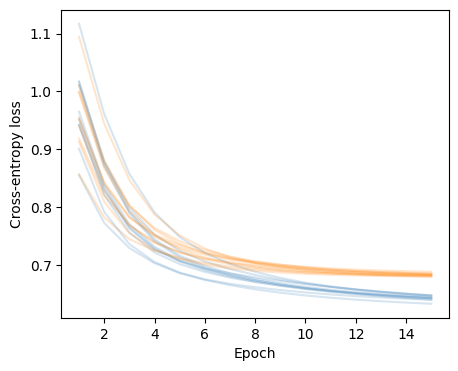

------------------------------ 
Training set:
Average log-likelihood = -4676.0 (19.6)
Average accuracy       = 73.3% (0.2%)
Average F1 score       = 67.5% (0.4%)
------------------------------ 
Validation set:
Average log-likelihood = -683.1 (2.5)
Average accuracy       = 72.7% (0.3%)
Average F1 score       = 67.0% (0.6%)
------------------------------ 
Test set:
Average log-likelihood = -1439.0 (6.0)
Average accuracy       = 71.3% (0.3%)
Average F1 score       = 65.4% (0.5%)
------------------------------ 
Training set:
Strong regularity = 0.998 (0.002)
Weak regularity   = 0.999 (0.002)
------------------------------ 
Validation set:
Strong regularity = 0.998 (0.003)
Weak regularity   = 0.999 (0.002)
------------------------------ 
Test set:
Strong regularity = 0.999 (0.001)
Weak regularity   = 1.000 (0.001)
------------------------------


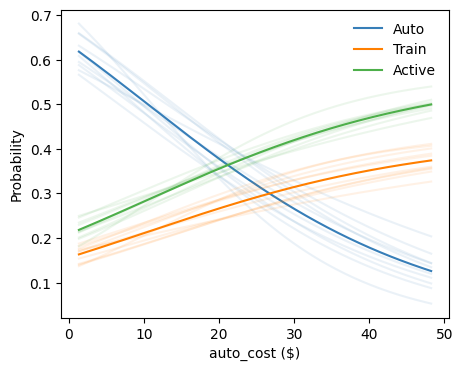

------------------------------ 
Model comparison:


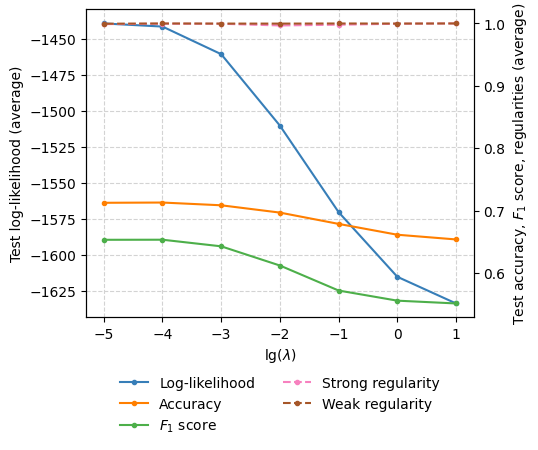

In [ ]:
# With sum
result(TasteNet, 15, 'UGR', [10**i for i in range(1, -6, -1)])

In [ ]:
# With norm
# result(TasteNet, 15, 'UGR', [10**i for i in range(1, -6, -1)], 'norm')

### LGR

Penalty = 10
------------------------------
Model 1 
Training set:   LL = -7261.5 | acc = 52.3% | F1 = 51.3%
Validation set: LL = -1039.6 | acc = 51.7% | F1 = 51.2%
Test set:       LL = -2067.3 | acc = 53.5% | F1 = 51.7%
Model 2 
Training set:   LL = -6854.5 | acc = 54.4% | F1 = 53.4%
Validation set: LL = -973.9  | acc = 53.5% | F1 = 52.9%
Test set:       LL = -1951.3 | acc = 54.6% | F1 = 52.9%
Model 3 
Training set:   LL = -6645.6 | acc = 57.3% | F1 = 52.6%
Validation set: LL = -940.5  | acc = 57.8% | F1 = 53.4%
Test set:       LL = -1913.2 | acc = 56.8% | F1 = 51.4%
Model 4 
Training set:   LL = -6659.6 | acc = 58.8% | F1 = 54.4%
Validation set: LL = -964.1  | acc = 57.9% | F1 = 53.8%
Test set:       LL = -1905.9 | acc = 59.0% | F1 = 54.1%
Model 5 
Training set:   LL = -6461.1 | acc = 56.5% | F1 = 54.9%
Validation set: LL = -909.2  | acc = 56.3% | F1 = 54.9%
Test set:       LL = -1880.8 | acc = 54.9% | F1 = 53.0%
Model 6 
Training set:   LL = -7102.7 | acc = 52.2% | F1 = 51.3%
Valida

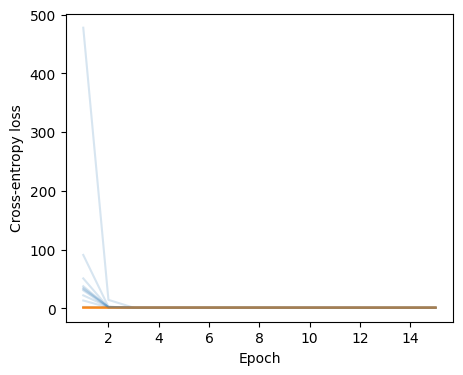

------------------------------ 
Training set:
Average log-likelihood = -6702.8 (314.1)
Average accuracy       = 56.5% (3.4%)
Average F1 score       = 53.9% (1.6%)
------------------------------ 
Validation set:
Average log-likelihood = -956.5 (46.4)
Average accuracy       = 55.9% (3.6%)
Average F1 score       = 53.7% (1.7%)
------------------------------ 
Test set:
Average log-likelihood = -1921.2 (83.5)
Average accuracy       = 56.3% (3.1%)
Average F1 score       = 53.2% (1.2%)
------------------------------ 
Training set:
Strong regularity = 1.000 (0.000)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Validation set:
Strong regularity = 1.000 (0.000)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Test set:
Strong regularity = 1.000 (0.000)
Weak regularity   = 1.000 (0.000)
------------------------------


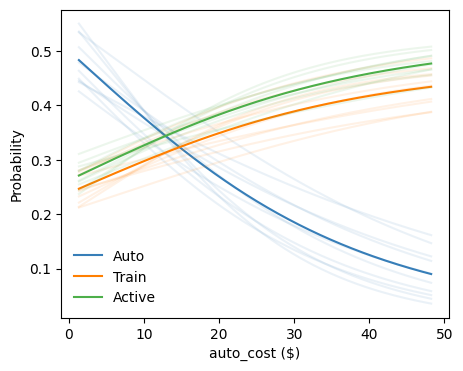

Penalty = 1
------------------------------
Model 1 
Training set:   LL = -6266.8 | acc = 61.2% | F1 = 55.0%
Validation set: LL = -894.6  | acc = 61.8% | F1 = 56.3%
Test set:       LL = -1807.1 | acc = 60.2% | F1 = 53.6%
Model 2 
Training set:   LL = -5683.5 | acc = 66.7% | F1 = 56.6%
Validation set: LL = -807.0  | acc = 66.9% | F1 = 56.8%
Test set:       LL = -1640.2 | acc = 65.0% | F1 = 54.3%
Model 3 
Training set:   LL = -6469.7 | acc = 59.3% | F1 = 53.5%
Validation set: LL = -914.7  | acc = 59.5% | F1 = 54.1%
Test set:       LL = -1866.6 | acc = 58.7% | F1 = 52.2%
Model 4 
Training set:   LL = -5526.5 | acc = 68.9% | F1 = 56.7%
Validation set: LL = -788.8  | acc = 69.3% | F1 = 57.1%
Test set:       LL = -1624.8 | acc = 67.4% | F1 = 54.7%
Model 5 
Training set:   LL = -5313.6 | acc = 69.5% | F1 = 57.4%
Validation set: LL = -744.1  | acc = 69.8% | F1 = 57.7%
Test set:       LL = -1584.8 | acc = 67.8% | F1 = 55.1%
Model 6 
Training set:   LL = -5788.9 | acc = 66.7% | F1 = 56.5%
Validat

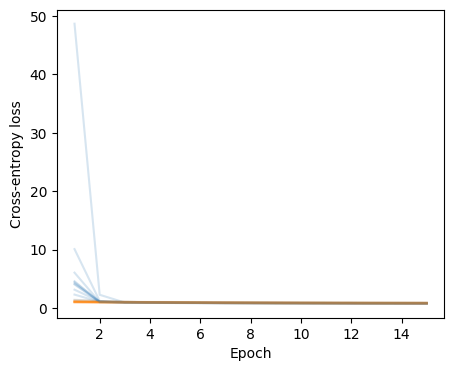

------------------------------ 
Training set:
Average log-likelihood = -5769.0 (375.1)
Average accuracy       = 66.3% (3.3%)
Average F1 score       = 56.5% (1.4%)
------------------------------ 
Validation set:
Average log-likelihood = -819.8 (54.6)
Average accuracy       = 66.4% (3.2%)
Average F1 score       = 56.9% (1.2%)
------------------------------ 
Test set:
Average log-likelihood = -1683.9 (93.2)
Average accuracy       = 64.8% (3.0%)
Average F1 score       = 54.7% (1.2%)
------------------------------ 
Training set:
Strong regularity = 0.999 (0.003)
Weak regularity   = 1.000 (0.001)
------------------------------ 
Validation set:
Strong regularity = 0.999 (0.002)
Weak regularity   = 1.000 (0.001)
------------------------------ 
Test set:
Strong regularity = 0.999 (0.003)
Weak regularity   = 1.000 (0.001)
------------------------------


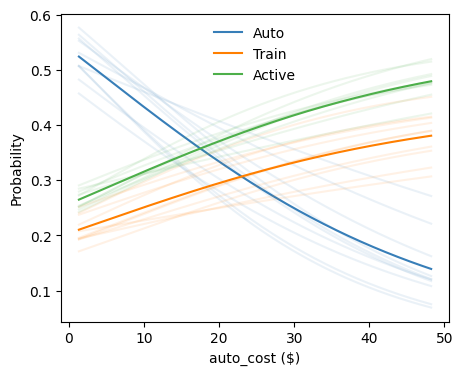

Penalty = 0.1
------------------------------
Model 1 
Training set:   LL = -5235.6 | acc = 69.3% | F1 = 57.0%
Validation set: LL = -745.5  | acc = 69.8% | F1 = 57.7%
Test set:       LL = -1563.9 | acc = 67.8% | F1 = 54.9%
Model 2 
Training set:   LL = -4991.9 | acc = 71.8% | F1 = 63.2%
Validation set: LL = -712.7  | acc = 71.9% | F1 = 63.2%
Test set:       LL = -1497.0 | acc = 70.0% | F1 = 61.5%
Model 3 
Training set:   LL = -5605.6 | acc = 68.6% | F1 = 56.8%
Validation set: LL = -791.7  | acc = 68.6% | F1 = 56.9%
Test set:       LL = -1644.2 | acc = 67.0% | F1 = 54.7%
Model 4 
Training set:   LL = -5024.7 | acc = 71.2% | F1 = 61.9%
Validation set: LL = -722.3  | acc = 71.3% | F1 = 61.7%
Test set:       LL = -1518.8 | acc = 69.6% | F1 = 60.3%
Model 5 
Training set:   LL = -4975.3 | acc = 72.2% | F1 = 64.8%
Validation set: LL = -704.0  | acc = 71.3% | F1 = 63.6%
Test set:       LL = -1506.6 | acc = 70.4% | F1 = 62.9%
Model 6 
Training set:   LL = -5132.1 | acc = 69.5% | F1 = 57.4%
Valid

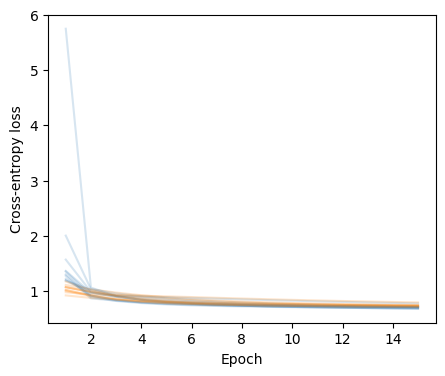

------------------------------ 
Training set:
Average log-likelihood = -5125.8 (181.1)
Average accuracy       = 70.7% (1.2%)
Average F1 score       = 60.8% (2.9%)
------------------------------ 
Validation set:
Average log-likelihood = -730.4 (24.0)
Average accuracy       = 70.7% (1.1%)
Average F1 score       = 60.7% (2.5%)
------------------------------ 
Test set:
Average log-likelihood = -1536.5 (41.3)
Average accuracy       = 68.9% (1.2%)
Average F1 score       = 58.5% (3.0%)
------------------------------ 
Training set:
Strong regularity = 0.996 (0.004)
Weak regularity   = 0.999 (0.001)
------------------------------ 
Validation set:
Strong regularity = 0.996 (0.005)
Weak regularity   = 0.999 (0.001)
------------------------------ 
Test set:
Strong regularity = 0.996 (0.005)
Weak regularity   = 0.999 (0.002)
------------------------------


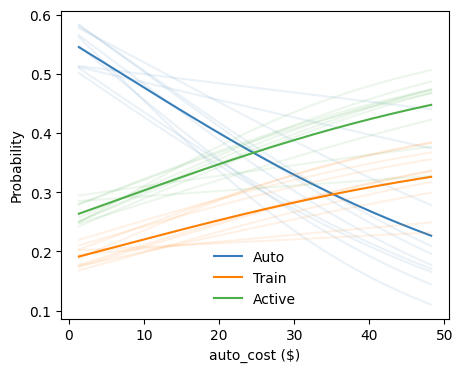

Penalty = 0.01
------------------------------
Model 1 
Training set:   LL = -4851.6 | acc = 72.3% | F1 = 65.0%
Validation set: LL = -696.7  | acc = 71.8% | F1 = 64.5%
Test set:       LL = -1488.4 | acc = 70.1% | F1 = 62.6%
Model 2 
Training set:   LL = -4761.9 | acc = 72.6% | F1 = 65.9%
Validation set: LL = -686.2  | acc = 72.2% | F1 = 65.6%
Test set:       LL = -1457.6 | acc = 70.8% | F1 = 63.9%
Model 3 
Training set:   LL = -4882.5 | acc = 71.8% | F1 = 63.6%
Validation set: LL = -699.9  | acc = 71.3% | F1 = 62.9%
Test set:       LL = -1482.0 | acc = 69.8% | F1 = 61.4%
Model 4 
Training set:   LL = -4787.3 | acc = 72.7% | F1 = 65.7%
Validation set: LL = -694.0  | acc = 71.9% | F1 = 64.8%
Test set:       LL = -1464.5 | acc = 70.5% | F1 = 63.3%
Model 5 
Training set:   LL = -4754.3 | acc = 72.8% | F1 = 66.4%
Validation set: LL = -682.8  | acc = 71.8% | F1 = 65.2%
Test set:       LL = -1455.1 | acc = 71.2% | F1 = 64.8%
Model 6 
Training set:   LL = -4820.3 | acc = 72.5% | F1 = 65.6%
Vali

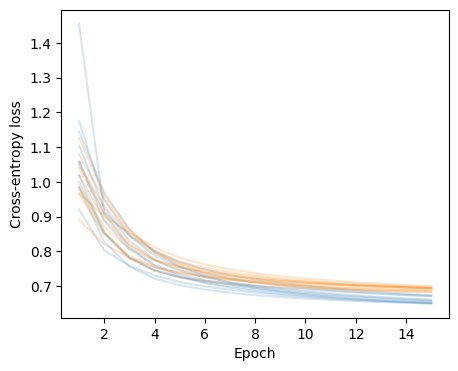

------------------------------ 
Training set:
Average log-likelihood = -4802.0 (46.5)
Average accuracy       = 72.5% (0.4%)
Average F1 score       = 65.6% (1.0%)
------------------------------ 
Validation set:
Average log-likelihood = -691.9 (5.3)
Average accuracy       = 71.8% (0.3%)
Average F1 score       = 64.7% (0.9%)
------------------------------ 
Test set:
Average log-likelihood = -1470.0 (13.0)
Average accuracy       = 70.6% (0.6%)
Average F1 score       = 63.4% (1.2%)
------------------------------ 
Training set:
Strong regularity = 0.998 (0.003)
Weak regularity   = 0.999 (0.001)
------------------------------ 
Validation set:
Strong regularity = 0.998 (0.004)
Weak regularity   = 0.999 (0.002)
------------------------------ 
Test set:
Strong regularity = 0.998 (0.003)
Weak regularity   = 0.999 (0.002)
------------------------------


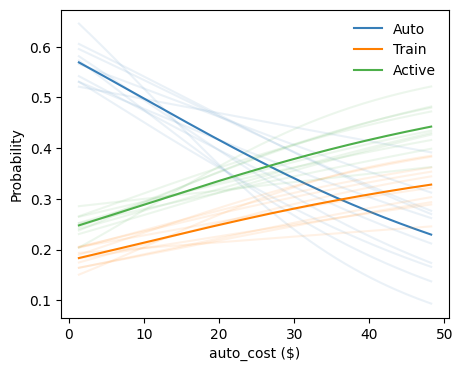

Penalty = 0.001
------------------------------
Model 1 
Training set:   LL = -4702.2 | acc = 73.2% | F1 = 67.1%
Validation set: LL = -684.7  | acc = 72.0% | F1 = 65.8%
Test set:       LL = -1446.9 | acc = 71.0% | F1 = 64.7%
Model 2 
Training set:   LL = -4690.9 | acc = 73.4% | F1 = 67.6%
Validation set: LL = -682.2  | acc = 72.8% | F1 = 66.8%
Test set:       LL = -1444.2 | acc = 71.4% | F1 = 65.4%
Model 3 
Training set:   LL = -4691.8 | acc = 73.0% | F1 = 67.0%
Validation set: LL = -681.9  | acc = 71.8% | F1 = 65.5%
Test set:       LL = -1441.3 | acc = 71.2% | F1 = 64.9%
Model 4 
Training set:   LL = -4694.5 | acc = 73.1% | F1 = 67.1%
Validation set: LL = -688.9  | acc = 72.1% | F1 = 65.7%
Test set:       LL = -1443.2 | acc = 71.1% | F1 = 64.9%
Model 5 
Training set:   LL = -4700.9 | acc = 73.0% | F1 = 67.1%
Validation set: LL = -680.0  | acc = 72.4% | F1 = 66.2%
Test set:       LL = -1440.9 | acc = 71.6% | F1 = 65.6%
Model 6 
Training set:   LL = -4697.8 | acc = 73.0% | F1 = 67.1%
Val

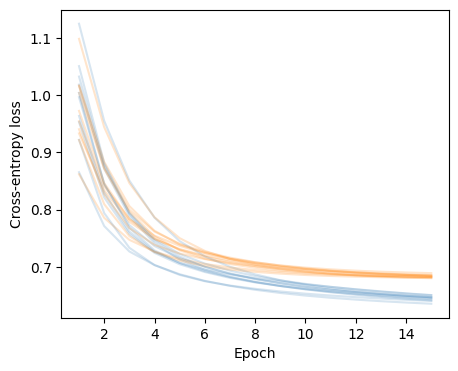

------------------------------ 
Training set:
Average log-likelihood = -4690.2 (18.4)
Average accuracy       = 73.1% (0.2%)
Average F1 score       = 67.2% (0.4%)
------------------------------ 
Validation set:
Average log-likelihood = -683.5 (2.5)
Average accuracy       = 72.4% (0.4%)
Average F1 score       = 66.4% (0.6%)
------------------------------ 
Test set:
Average log-likelihood = -1443.2 (6.0)
Average accuracy       = 71.3% (0.3%)
Average F1 score       = 65.2% (0.6%)
------------------------------ 
Training set:
Strong regularity = 0.999 (0.001)
Weak regularity   = 1.000 (0.001)
------------------------------ 
Validation set:
Strong regularity = 1.000 (0.001)
Weak regularity   = 1.000 (0.001)
------------------------------ 
Test set:
Strong regularity = 0.999 (0.002)
Weak regularity   = 0.999 (0.002)
------------------------------


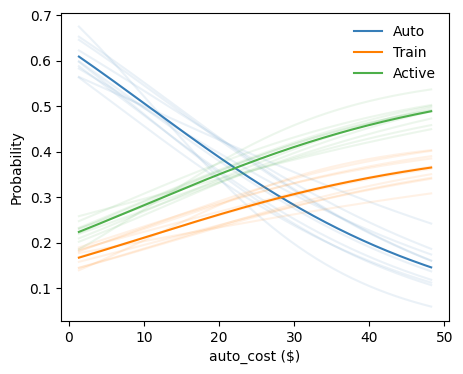

Penalty = 0.0001
------------------------------
Model 1 
Training set:   LL = -4680.2 | acc = 73.2% | F1 = 67.4%
Validation set: LL = -684.8  | acc = 72.8% | F1 = 67.1%
Test set:       LL = -1438.5 | acc = 70.9% | F1 = 64.6%
Model 2 
Training set:   LL = -4679.2 | acc = 73.6% | F1 = 68.0%
Validation set: LL = -682.5  | acc = 72.9% | F1 = 67.1%
Test set:       LL = -1441.3 | acc = 71.5% | F1 = 65.6%
Model 3 
Training set:   LL = -4663.8 | acc = 73.3% | F1 = 67.6%
Validation set: LL = -681.1  | acc = 72.5% | F1 = 66.7%
Test set:       LL = -1433.6 | acc = 71.3% | F1 = 65.3%
Model 4 
Training set:   LL = -4683.0 | acc = 73.1% | F1 = 67.2%
Validation set: LL = -688.4  | acc = 72.3% | F1 = 66.1%
Test set:       LL = -1440.5 | acc = 71.0% | F1 = 64.9%
Model 5 
Training set:   LL = -4699.2 | acc = 73.0% | F1 = 67.1%
Validation set: LL = -679.9  | acc = 72.6% | F1 = 66.6%
Test set:       LL = -1438.1 | acc = 71.5% | F1 = 65.7%
Model 6 
Training set:   LL = -4683.3 | acc = 73.2% | F1 = 67.3%
Va

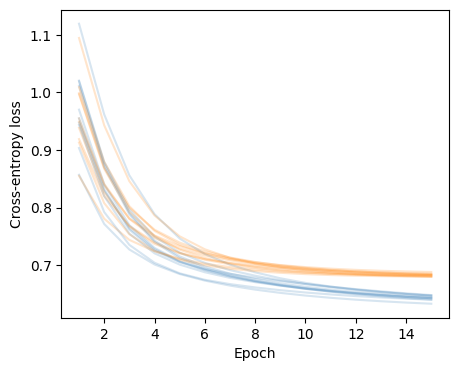

------------------------------ 
Training set:
Average log-likelihood = -4675.7 (19.2)
Average accuracy       = 73.2% (0.2%)
Average F1 score       = 67.5% (0.4%)
------------------------------ 
Validation set:
Average log-likelihood = -683.1 (2.5)
Average accuracy       = 72.7% (0.3%)
Average F1 score       = 66.9% (0.6%)
------------------------------ 
Test set:
Average log-likelihood = -1438.4 (6.1)
Average accuracy       = 71.3% (0.2%)
Average F1 score       = 65.4% (0.5%)
------------------------------ 
Training set:
Strong regularity = 0.998 (0.002)
Weak regularity   = 0.999 (0.001)
------------------------------ 
Validation set:
Strong regularity = 0.998 (0.002)
Weak regularity   = 0.999 (0.002)
------------------------------ 
Test set:
Strong regularity = 0.999 (0.001)
Weak regularity   = 1.000 (0.001)
------------------------------


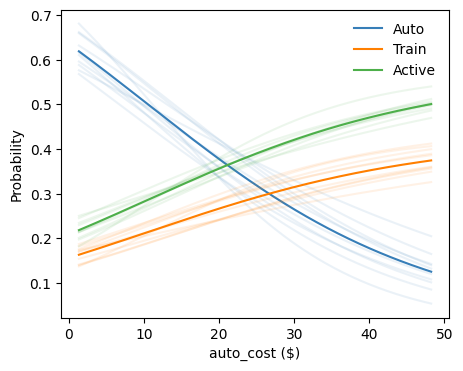

Penalty = 1e-05
------------------------------
Model 1 
Training set:   LL = -4682.7 | acc = 73.2% | F1 = 67.4%
Validation set: LL = -684.9  | acc = 72.5% | F1 = 66.8%
Test set:       LL = -1439.1 | acc = 70.9% | F1 = 64.7%
Model 2 
Training set:   LL = -4679.1 | acc = 73.6% | F1 = 68.0%
Validation set: LL = -682.5  | acc = 73.0% | F1 = 67.2%
Test set:       LL = -1441.0 | acc = 71.4% | F1 = 65.5%
Model 3 
Training set:   LL = -4662.7 | acc = 73.2% | F1 = 67.6%
Validation set: LL = -681.1  | acc = 72.5% | F1 = 66.7%
Test set:       LL = -1433.2 | acc = 71.4% | F1 = 65.4%
Model 4 
Training set:   LL = -4683.6 | acc = 73.2% | F1 = 67.3%
Validation set: LL = -688.0  | acc = 72.4% | F1 = 66.2%
Test set:       LL = -1440.1 | acc = 71.0% | F1 = 64.8%
Model 5 
Training set:   LL = -4702.9 | acc = 73.0% | F1 = 67.2%
Validation set: LL = -679.7  | acc = 72.6% | F1 = 66.6%
Test set:       LL = -1438.1 | acc = 71.6% | F1 = 65.8%
Model 6 
Training set:   LL = -4688.6 | acc = 73.2% | F1 = 67.3%
Val

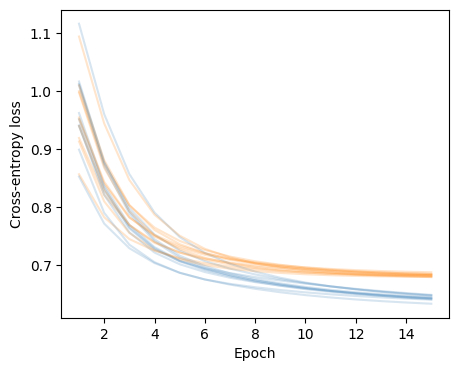

------------------------------ 
Training set:
Average log-likelihood = -4677.4 (19.8)
Average accuracy       = 73.2% (0.2%)
Average F1 score       = 67.5% (0.4%)
------------------------------ 
Validation set:
Average log-likelihood = -683.0 (2.4)
Average accuracy       = 72.6% (0.4%)
Average F1 score       = 66.8% (0.7%)
------------------------------ 
Test set:
Average log-likelihood = -1438.2 (5.9)
Average accuracy       = 71.3% (0.3%)
Average F1 score       = 65.4% (0.5%)
------------------------------ 
Training set:
Strong regularity = 0.998 (0.002)
Weak regularity   = 0.999 (0.002)
------------------------------ 
Validation set:
Strong regularity = 0.997 (0.004)
Weak regularity   = 0.998 (0.003)
------------------------------ 
Test set:
Strong regularity = 0.998 (0.002)
Weak regularity   = 0.999 (0.002)
------------------------------


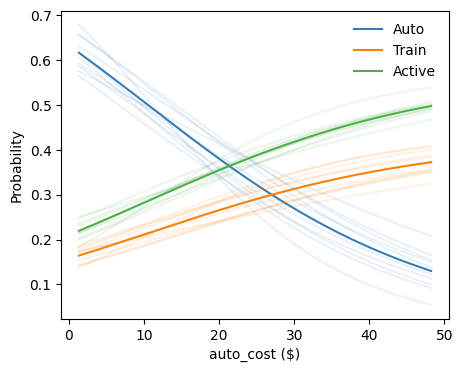

------------------------------ 
Model comparison:


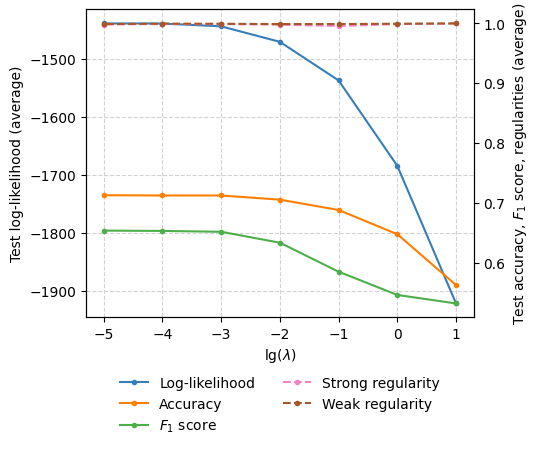

In [ ]:
# With sum
result(TasteNet, 15, 'LGR', [10**i for i in range(1, -6, -1)])

In [ ]:
# With norm
# result(TasteNet, 15, 'LGR', [10**i for i in range(1, -6, -1)], 'norm')

# Final results

In [ ]:
weights = np.array([2/val_size, .5, .5, 1, 1])
scores = results_val.multiply(weights, axis=0).sum()
l_col = []
for model in ['DNN', 'TasteNet']:
    l_col.append(model)
    for GR in ['PGR', 'UGR', 'LGR']:
        l_col.append(scores[scores.index.str.startswith(f'{model}, sum-{GR}')].idxmax())
l_col.append('MNL')

In [ ]:
results_train = results_train[l_col]
results_val = results_val[l_col].iloc[:5]
results_test = results_test[l_col]

results_train_std = results_train_std[l_col]
results_val_std = results_val_std[l_col]
results_test_std = results_test_std[l_col]

In [ ]:
results_train.to_csv(f'{path}/Regularity_results/10K_Chicago_train.csv')
results_val.to_csv(f'{path}/Regularity_results/10K_Chicago_val.csv')
results_test.to_csv(f'{path}/Regularity_results/10K_Chicago_test.csv')

results_train_std.to_csv(f'{path}/Regularity_results/10K_Chicago_train_std.csv')
results_val_std.to_csv(f'{path}/Regularity_results/10K_Chicago_val_std.csv')
results_test_std.to_csv(f'{path}/Regularity_results/10K_Chicago_test_std.csv')

In [ ]:
results_train.iloc[0] = results_train.iloc[0].round(1)
results_val.iloc[0] = results_val.iloc[0].round(1)
results_test.iloc[0] = results_test.iloc[0].round(1)

In [ ]:
df_train = results_train.round(3).astype(str).add(' (').add(results_train_std.round(3).astype(str)).add(')')
df_val = results_val.round(3).astype(str).add(' (').add(results_val_std.round(3).astype(str)).add(')')
df_test = results_test.round(3).astype(str).add(' (').add(results_test_std.round(3).astype(str)).add(')')

In [ ]:
print(df_train.to_latex())

\begin{tabular}{llllllllll}
\toprule
 & DNN & DNN, sum-PGR (0.01) & DNN, sum-UGR (0.01) & DNN, sum-LGR (0.01) & TasteNet & TasteNet, sum-PGR (0.0001) & TasteNet, sum-UGR (1e-05) & TasteNet, sum-LGR (0.0001) & MNL \\
\midrule
Log-likelihood & -4272.7 (12.975) & -4216.5 (11.737) & -4240.1 (15.399) & -4221.9 (17.58) & -4677.8 (19.892) & -4675.8 (19.385) & -4676.0 (19.572) & -4675.7 (19.245) & -4710.2 (0) \\
Accuracy & 0.751 (0.002) & 0.753 (0.002) & 0.752 (0.002) & 0.753 (0.002) & 0.732 (0.002) & 0.732 (0.002) & 0.733 (0.002) & 0.732 (0.002) & 0.731 (0) \\
F1 score & 0.717 (0.004) & 0.726 (0.004) & 0.721 (0.003) & 0.724 (0.004) & 0.675 (0.004) & 0.675 (0.004) & 0.675 (0.004) & 0.675 (0.004) & 0.681 (0) \\
Strong regularity & 0.889 (0.061) & 0.987 (0.003) & 0.98 (0.011) & 0.988 (0.003) & 0.997 (0.003) & 0.998 (0.002) & 0.998 (0.002) & 0.998 (0.002) & 0.998 (0) \\
Weak regularity & 0.927 (0.058) & 0.999 (0.001) & 0.997 (0.004) & 0.999 (0.001) & 0.999 (0.002) & 0.999 (0.001) & 0.999 (0.002) 

In [ ]:
print(df_val.to_latex())

\begin{tabular}{llllllllll}
\toprule
 & DNN & DNN, sum-PGR (0.01) & DNN, sum-UGR (0.01) & DNN, sum-LGR (0.01) & TasteNet & TasteNet, sum-PGR (0.0001) & TasteNet, sum-UGR (1e-05) & TasteNet, sum-LGR (0.0001) & MNL \\
\midrule
Log-likelihood & -633.6 (2.507) & -633.0 (2.474) & -634.1 (3.594) & -634.2 (2.794) & -683.0 (2.442) & -683.1 (2.47) & -683.1 (2.482) & -683.1 (2.467) & -693.8 (0) \\
Accuracy & 0.739 (0.004) & 0.739 (0.004) & 0.739 (0.003) & 0.739 (0.003) & 0.726 (0.004) & 0.727 (0.003) & 0.727 (0.003) & 0.727 (0.003) & 0.737 (0) \\
F1 score & 0.702 (0.005) & 0.71 (0.004) & 0.705 (0.005) & 0.708 (0.003) & 0.668 (0.007) & 0.669 (0.006) & 0.67 (0.006) & 0.669 (0.006) & 0.69 (0) \\
Strong regularity & 0.879 (0.058) & 0.981 (0.005) & 0.973 (0.014) & 0.982 (0.005) & 0.997 (0.005) & 0.999 (0.002) & 0.998 (0.003) & 0.998 (0.002) & 1.0 (0) \\
Weak regularity & 0.928 (0.057) & 0.999 (0.001) & 0.997 (0.004) & 0.999 (0.001) & 0.998 (0.003) & 0.999 (0.002) & 0.999 (0.002) & 0.999 (0.002) & 1.0

In [ ]:
print(df_test.to_latex())

\begin{tabular}{llllllllll}
\toprule
 & DNN & DNN, sum-PGR (0.01) & DNN, sum-UGR (0.01) & DNN, sum-LGR (0.01) & TasteNet & TasteNet, sum-PGR (0.0001) & TasteNet, sum-UGR (1e-05) & TasteNet, sum-LGR (0.0001) & MNL \\
\midrule
Log-likelihood & -1351.9 (4.697) & -1344.3 (5.521) & -1350.2 (5.803) & -1347.4 (5.11) & -1438.3 (5.834) & -1438.4 (6.027) & -1439.0 (5.992) & -1438.4 (6.099) & -1426.3 (0) \\
Accuracy & 0.729 (0.003) & 0.73 (0.002) & 0.729 (0.002) & 0.729 (0.002) & 0.713 (0.003) & 0.713 (0.002) & 0.713 (0.003) & 0.713 (0.002) & 0.718 (0) \\
F1 score & 0.691 (0.005) & 0.698 (0.004) & 0.694 (0.004) & 0.696 (0.004) & 0.654 (0.006) & 0.654 (0.005) & 0.654 (0.005) & 0.654 (0.005) & 0.669 (0) \\
Strong regularity & 0.888 (0.066) & 0.99 (0.003) & 0.982 (0.012) & 0.991 (0.003) & 0.998 (0.002) & 0.999 (0.001) & 0.999 (0.001) & 0.999 (0.001) & 0.998 (0) \\
Weak regularity & 0.922 (0.061) & 0.999 (0.001) & 0.996 (0.006) & 0.999 (0.001) & 0.999 (0.002) & 1.0 (0.001) & 1.0 (0.001) & 1.0 (0.001)